# Compare 202405-2xrez to 202405 Bathymetry - Tile Rows 16 to 22

Detailed, tile by tile, comparison of 202405-2xrez and 202405 bathymetries including preliminary river files.
This notebook is used iteratively with the `Process202405-2xrezBathymetry.ipynb` notebook to identify features
in the 2xrez bathymetry that need to be adjusted in the latter notebook.

This notebook is based on the ones that Susan created to do the same thing during the creation of the 202108
bathymetry (which was known as 202103d at the time):
* `analysis-susan/notebooks/bathymetry/lookat201702_201803d_andrivers.ipynb`
* `analysis-susan/notebooks/bathymetry/lookat201702_201803d_middle.ipynb`
* `analysis-susan/notebooks/bathymetry/lookat201702_201803d_upper.ipynb`

The conda environment file for this notebook is `environment-2xrez.yaml`.

In [1]:
from pathlib import Path
import sys

import cmocean.cm as cm
import matplotlib.pyplot as plt
import numpy
import xarray

from plot_tile import plot_tile
from salishsea_tools import viz_tools

Python and library versions:

In [2]:
import bottleneck
import cmocean
import h5netcdf
import h5py
import matplotlib
import netCDF4
import numpy
import pandas
import scipy
import xarray

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
netCDF4.__version__='1.6.5'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
cmocean.__version__='v3.0.3'


## Load Bathymetry Datasets

In [3]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")
repos_prefix = repos_prefix if repos_prefix.exists() else Path("/data/dlatorne/MEOPAR/")
# repos_prefix = Path("/home/sallen/MEOPAR/")

In [4]:
bathy_paths = {
    "final_202405": repos_prefix / "grid" / "bathymetry_202405.nc",
    "dbl_202405_base": repos_prefix / "grid" / "bathymetry_double_202405_base.nc",
    "dbl_202405": repos_prefix / "grid" / "bathymetry_double_202405.nc",
}

In [5]:
with xarray.open_dataset(bathy_paths["final_202405"], engine="h5netcdf") as bathy_ds:
    bathy = bathy_ds.Bathymetry
    lons = bathy_ds.nav_lon
    lats = bathy_ds.nav_lat

with xarray.open_dataset(bathy_paths["dbl_202405_base"], engine="h5netcdf") as dbl_bathy_base_ds:
    dbl_bathy_base_unmasked = dbl_bathy_base_ds.Bathymetry
    dbl_bathy_base = dbl_bathy_base_unmasked.where(dbl_bathy_base_unmasked != 0, numpy.nan)
    lons_dbl = dbl_bathy_base_ds.nav_lon
    lats_dbl = dbl_bathy_base_ds.nav_lat

with xarray.open_dataset(bathy_paths["dbl_202405"], engine="h5netcdf") as dbl_bathy_ds:
    dbl_bathy = dbl_bathy_ds.Bathymetry

Calculate expanded `lons` and `lats` arrays by extrapolating values on south and east edges.
This provides arrays that `pcoulormesh()` interprets as cell edges so that it doesn't a
`UserWarning` about the non-montonic lon/lat values that arise due to the rotated grid.
This code is based on Michael's `expandf()` function in
https://github.com/SalishSeaCast/analysis-michael/blob/master/bathymetry/bathy_helpers.py

In [6]:
lons_e = numpy.zeros((lons.shape[0]+1, lons.shape[1]+1))
lons_e[1:, 1:] = lons
lons_e[0, 1:] = lons[0, :] - (lons[1, :] - lons[0, :])
lons_e[:, 0] = lons_e[:, 1] - (lons_e[:, 2] - lons_e[:, 1])

lats_e = numpy.zeros((lats.shape[0]+1, lats.shape[1]+1))
lats_e[1:, 1:] = lats
lats_e[0, 1:] = lats[0, :] - (lats[1, :] - lats[0, :])
lats_e[:, 0] = lats_e[:, 1] - (lats_e[:, 2] - lats_e[:, 1])

lons_dbl_e = numpy.zeros((lons_dbl.shape[0]+1, lons_dbl.shape[1]+1))
lons_dbl_e[1:, 1:] = lons_dbl
lons_dbl_e[0, 1:] = lons_dbl[0, :] - (lons_dbl[1, :] - lons_dbl[0, :])
lons_dbl_e[:, 0] = lons_dbl_e[:, 1] - (lons_dbl_e[:, 2] - lons_dbl_e[:, 1])

lats_dbl_e = numpy.zeros((lats_dbl.shape[0]+1, lats_dbl.shape[1]+1))
lats_dbl_e[1:, 1:] = lats_dbl
lats_dbl_e[0, 1:] = lats_dbl[0, :] - (lats_dbl[1, :] - lats_dbl[0, :])
lats_dbl_e[:, 0] = lats_dbl_e[:, 1] - (lats_dbl_e[:, 2] - lats_dbl_e[:, 1])


## x-index Array

In [7]:
tile_x_min_max = [
    numpy.array([0, 35]),
    numpy.array([30, 65]),
    numpy.array([60, 95]),
    numpy.array([90, 125]),
    numpy.array([120, 155]),
    numpy.array([150, 185]),
    numpy.array([180, 215]),
    numpy.array([210, 245]),
    numpy.array([240, 275]),
    numpy.array([270, 305]),
    numpy.array([300, 335]),
    numpy.array([330, 365]),
    numpy.array([360, 398]),
]

## Row 16 - Nanoose Bay to Howe Sound

In [8]:
y_min_max = numpy.array([505, 540])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 16, 0

* all land

### Tile 16, 1

* all land

### Tile 16, 2

* all land

### Tile 16, 3

* all land

### Tile 16, 4

* all land

### Tile 16, 5

* almost all land

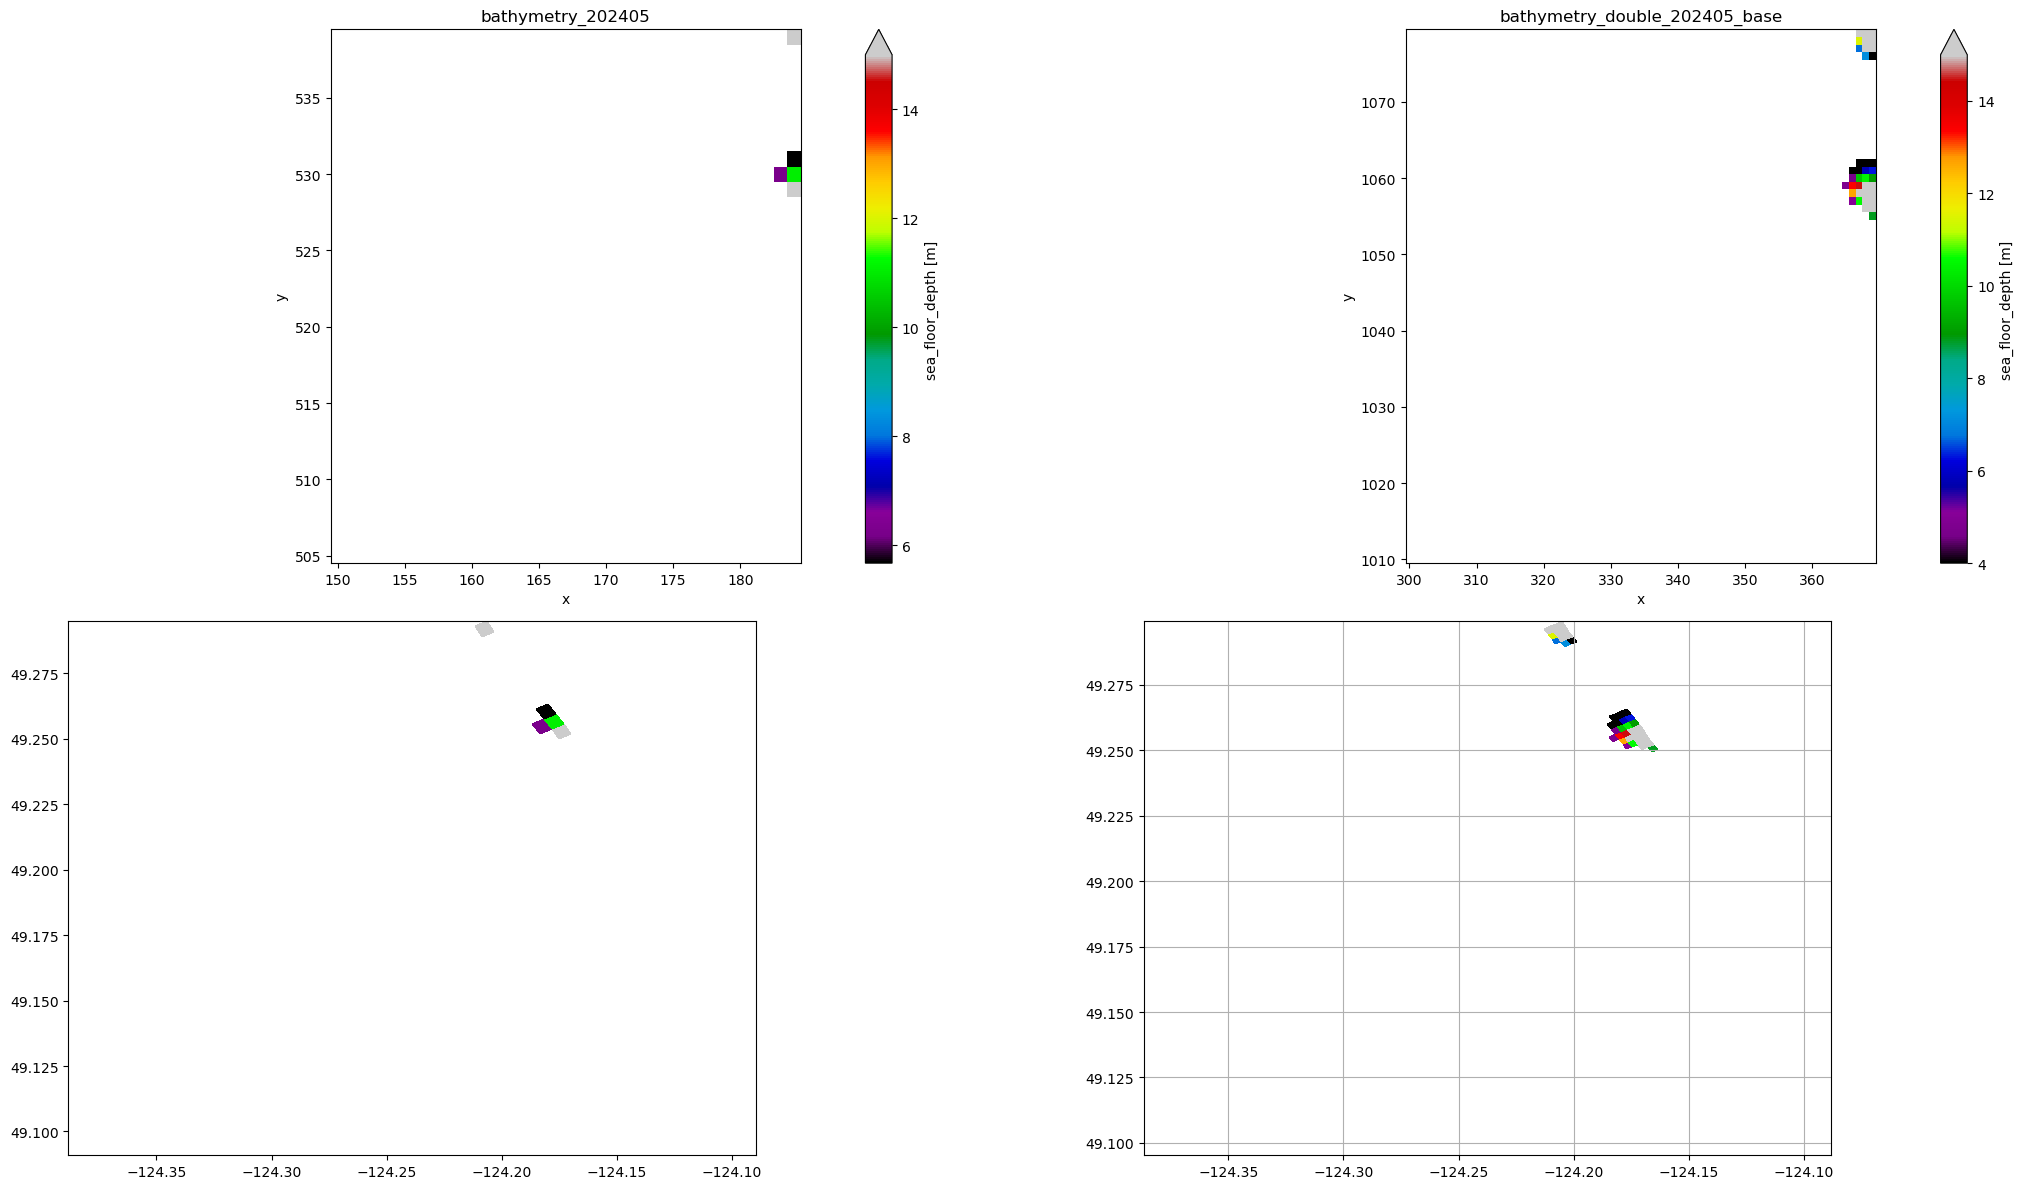

In [9]:
plot_tile(tile_x_min_max[5], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e);

### Tile 16, 6 - Nanoose Bay

* surface Southey Island
* surface Ruth Island
* surface Winchelsea Islands
* surface Yeo Islands

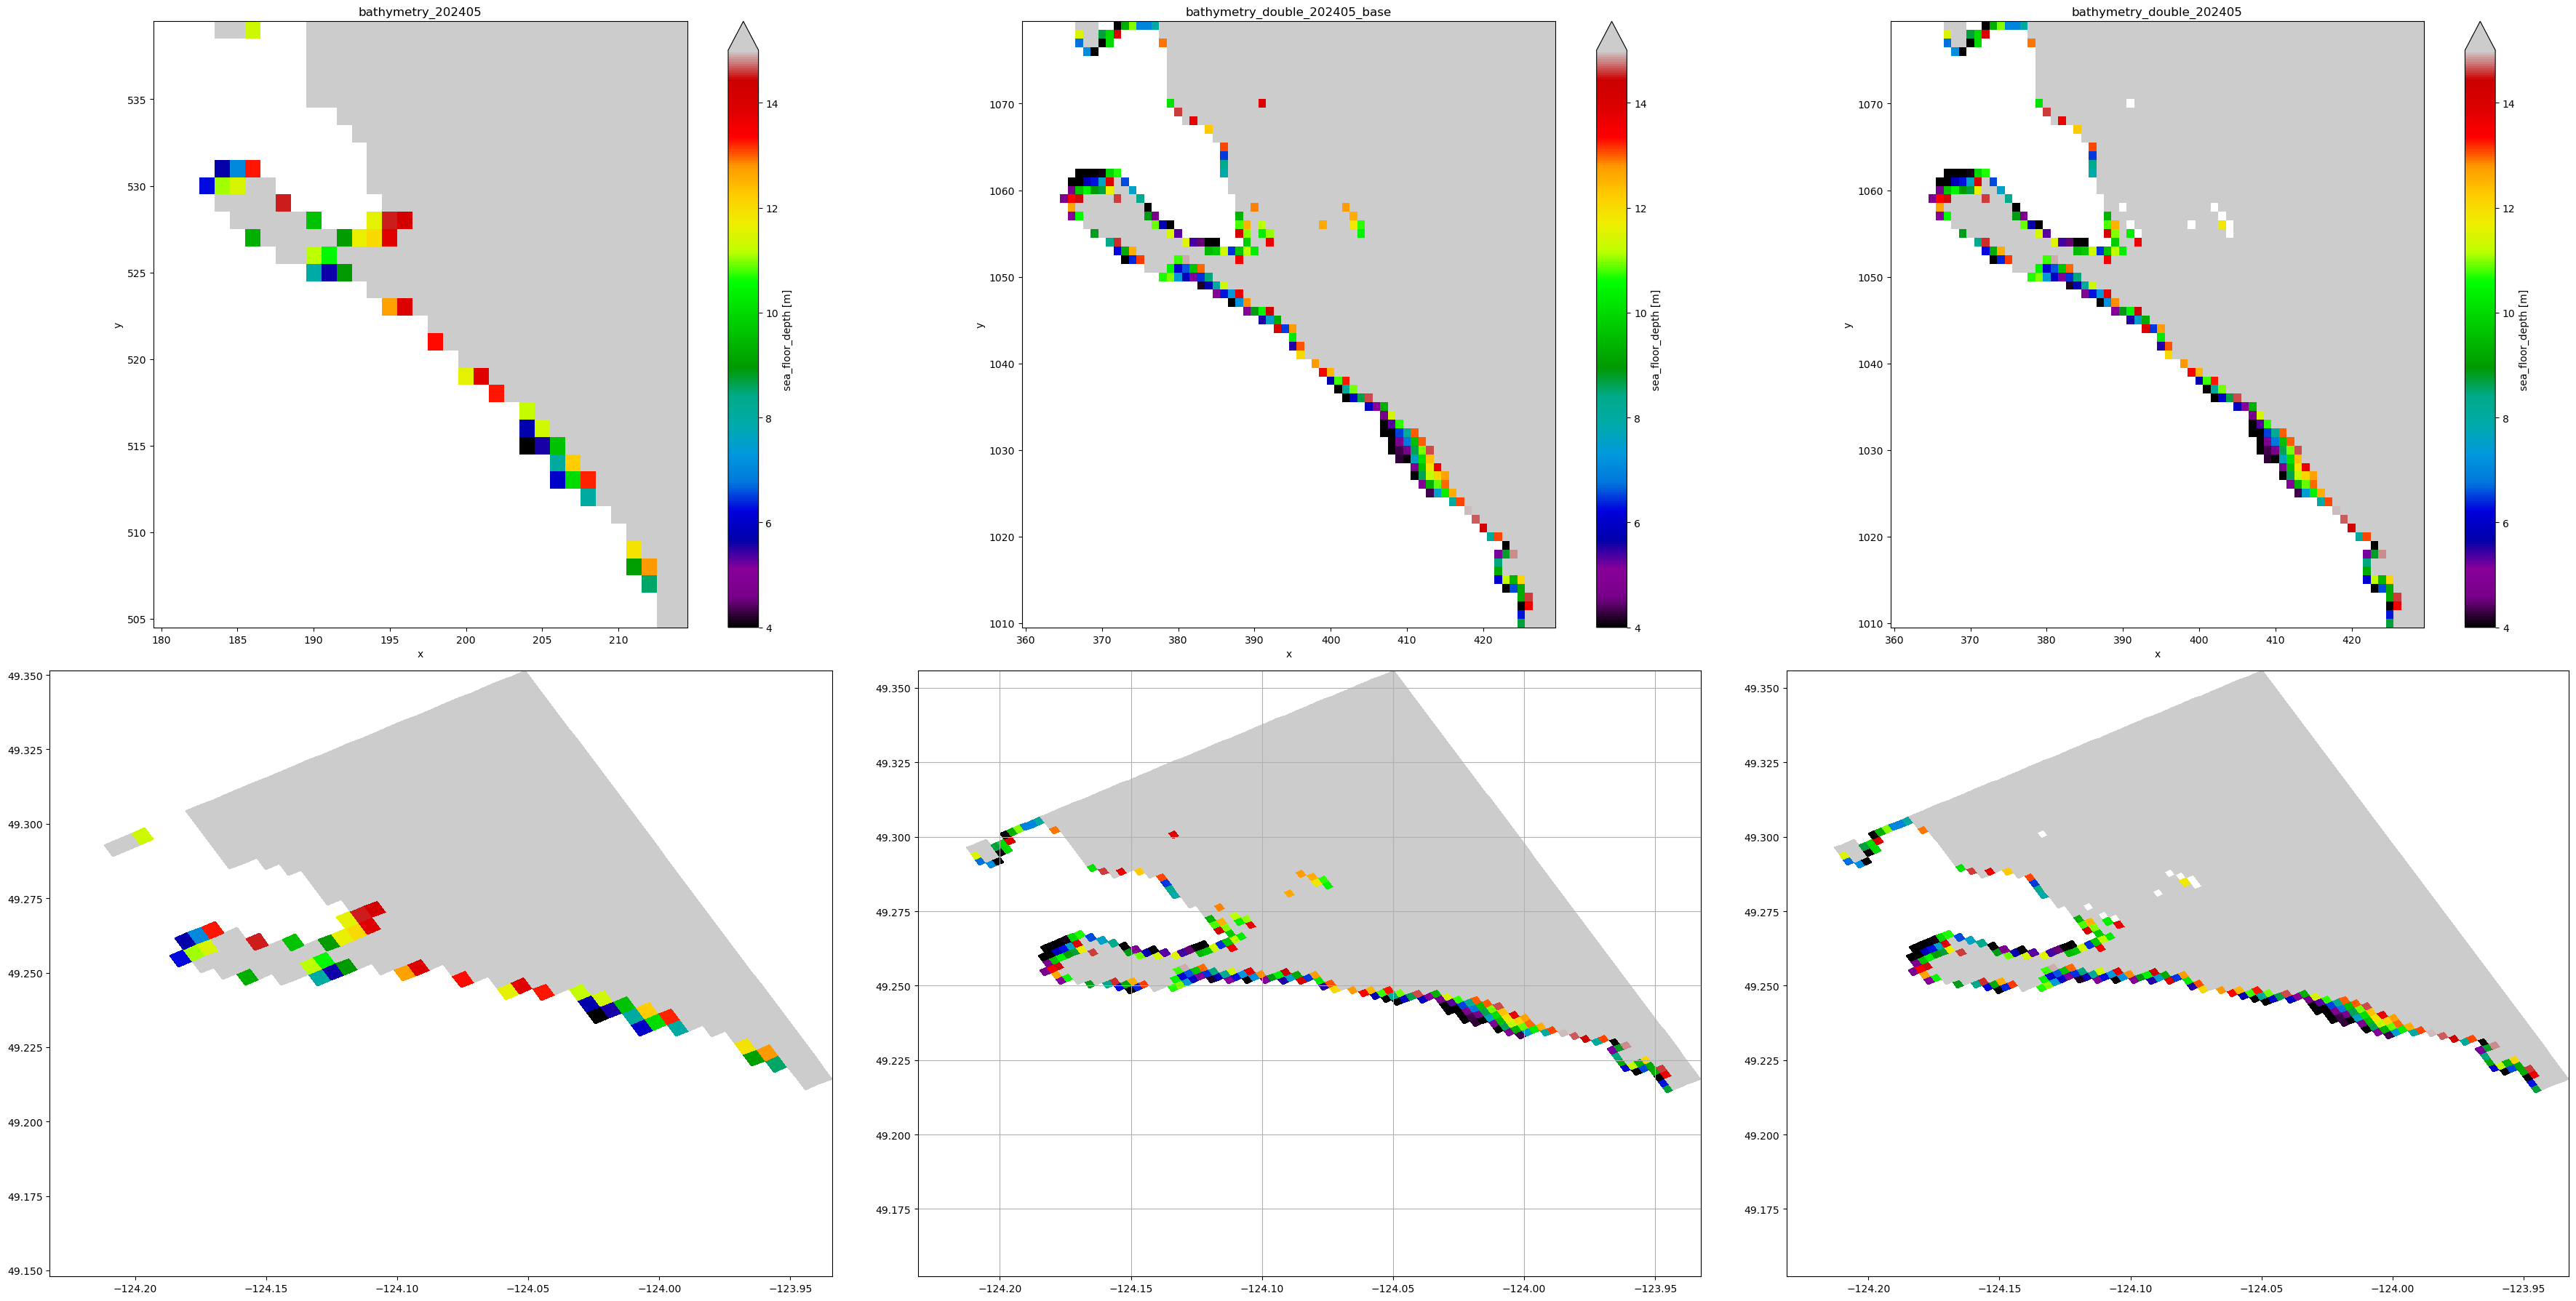

In [10]:
plot_tile(tile_x_min_max[6], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e, dbl_bathy);

### Tile 16, 7 - Strait of Georgia

* almost all deep water

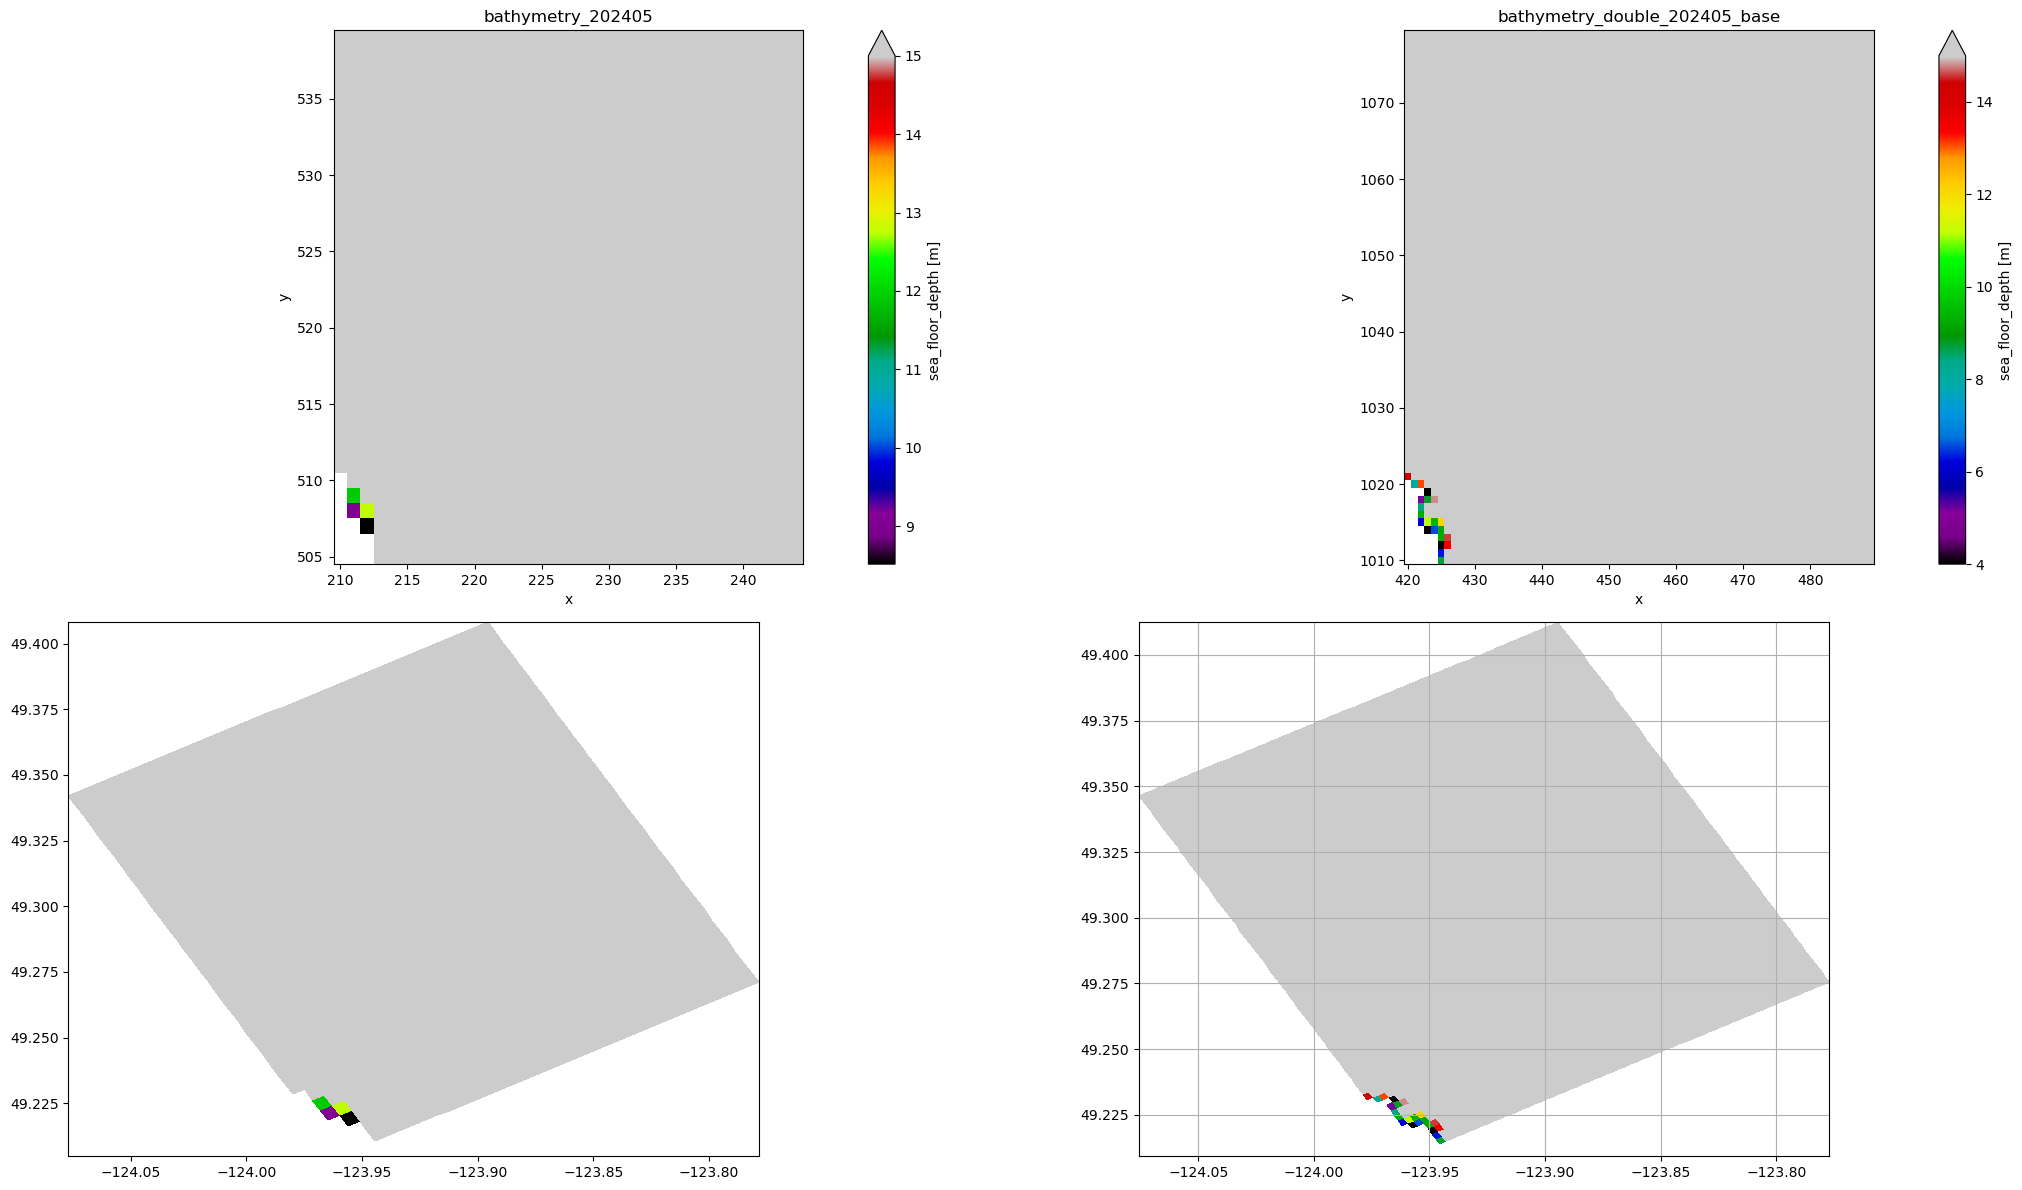

In [11]:
plot_tile(tile_x_min_max[7], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e);

### Tile 16, 8 - Strait of Georgia

* almost all deep water

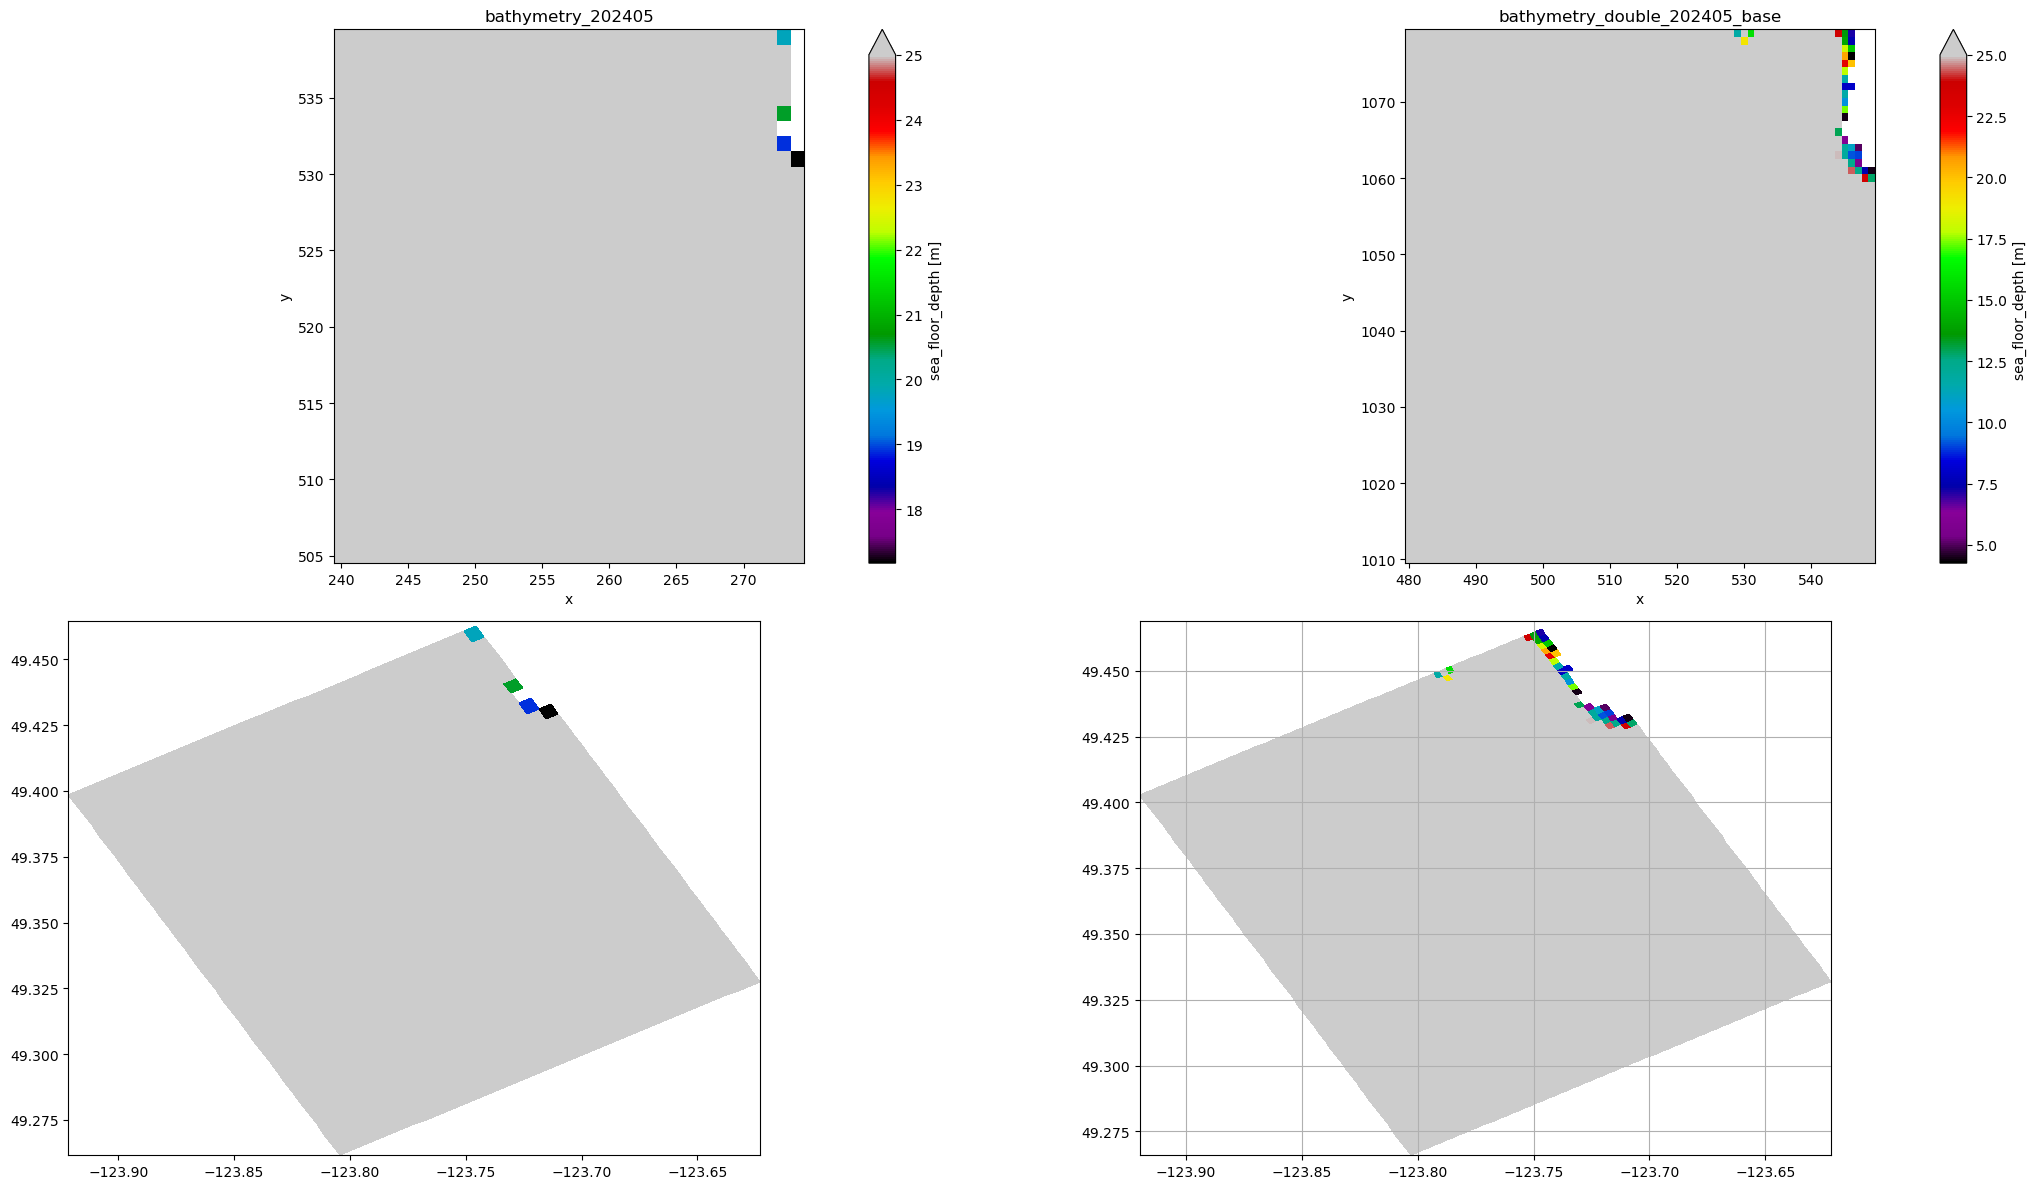

In [12]:
plot_tile(tile_x_min_max[8], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e, vmax=25);

### Tile 16, 9 - Roberts Creek

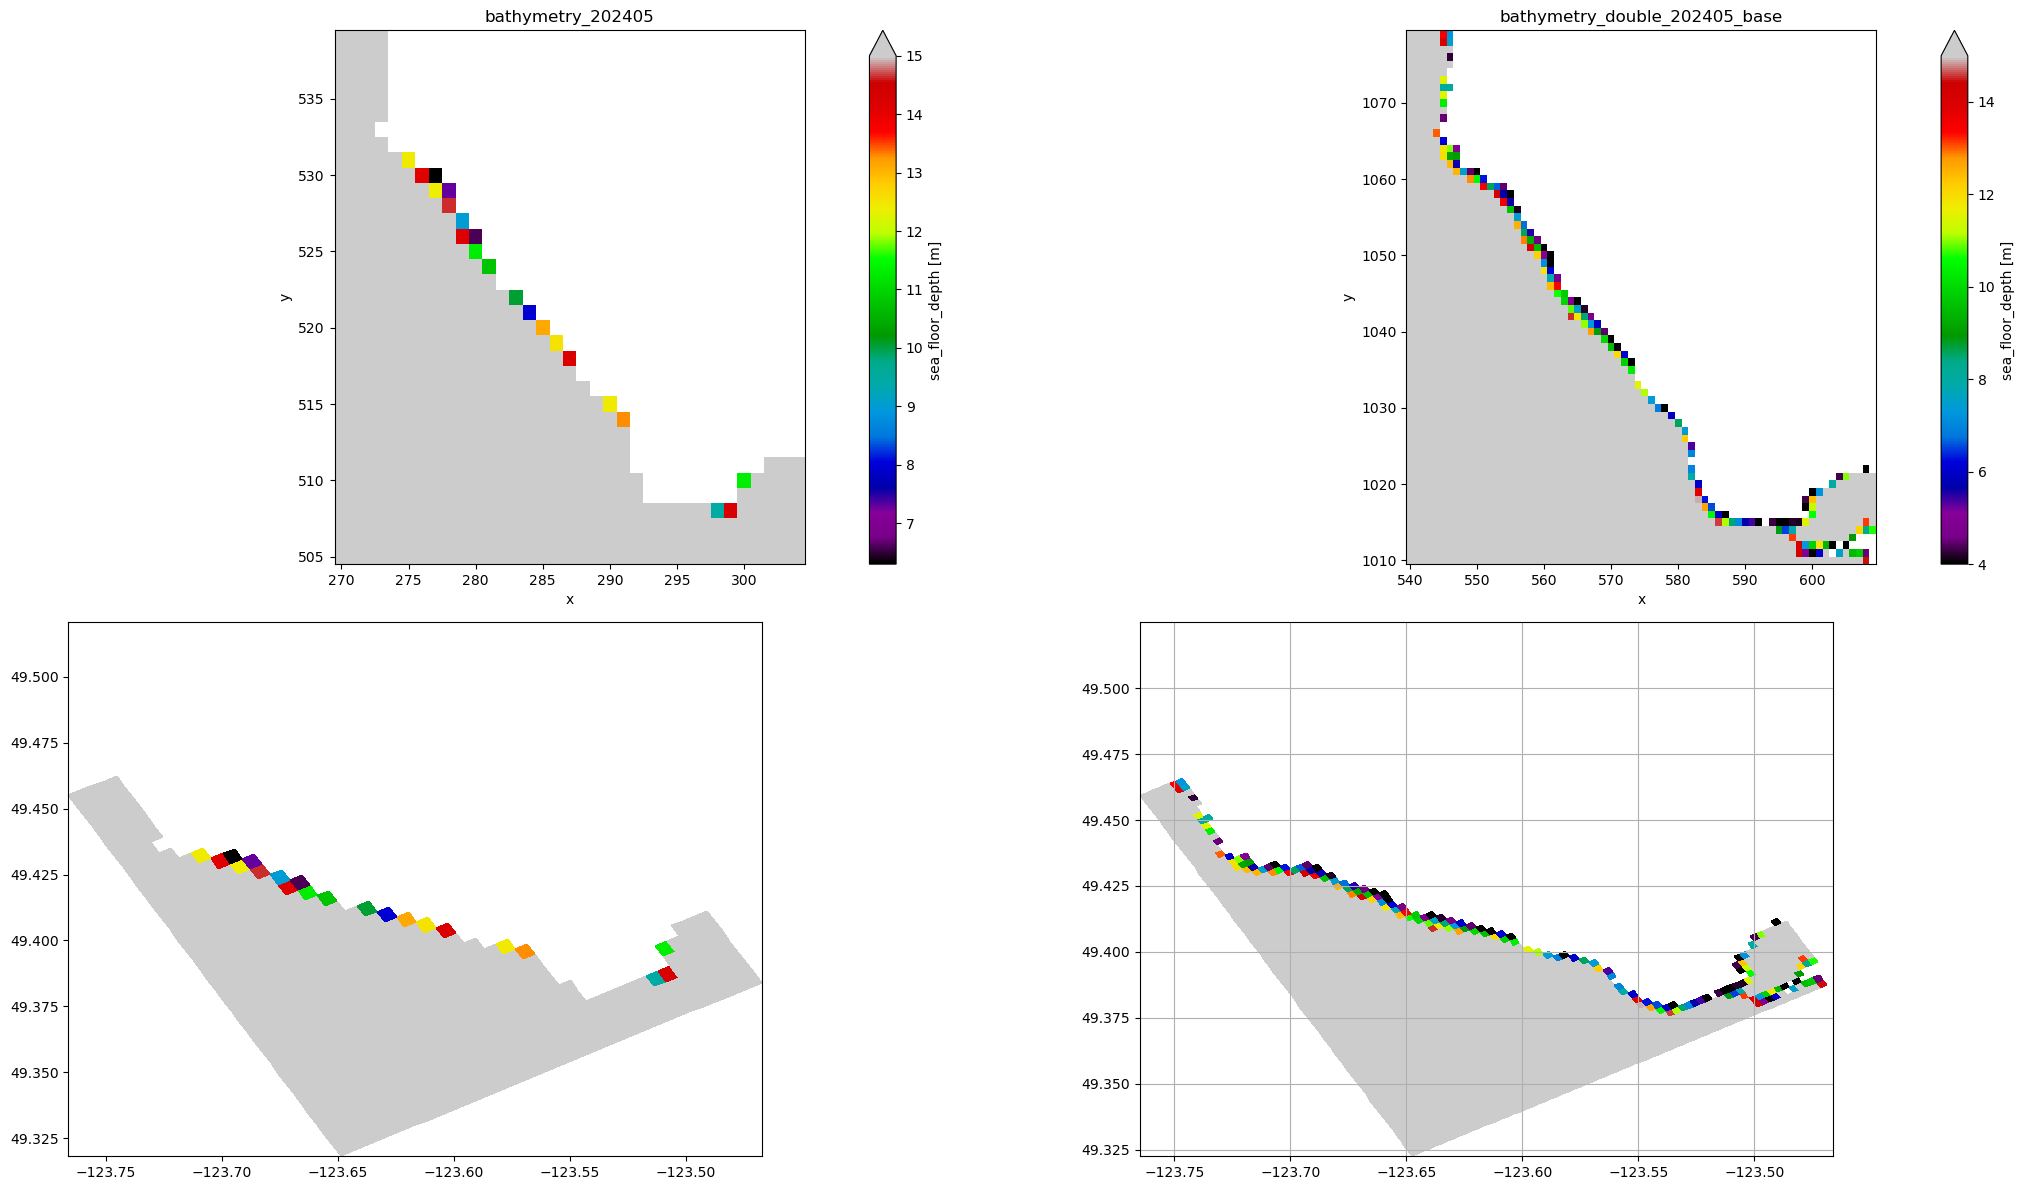

In [13]:
plot_tile(tile_x_min_max[9], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e);

### Tile 16, 10 - Gambier Island

* remove fake islet off the end of the 3rd peninsula

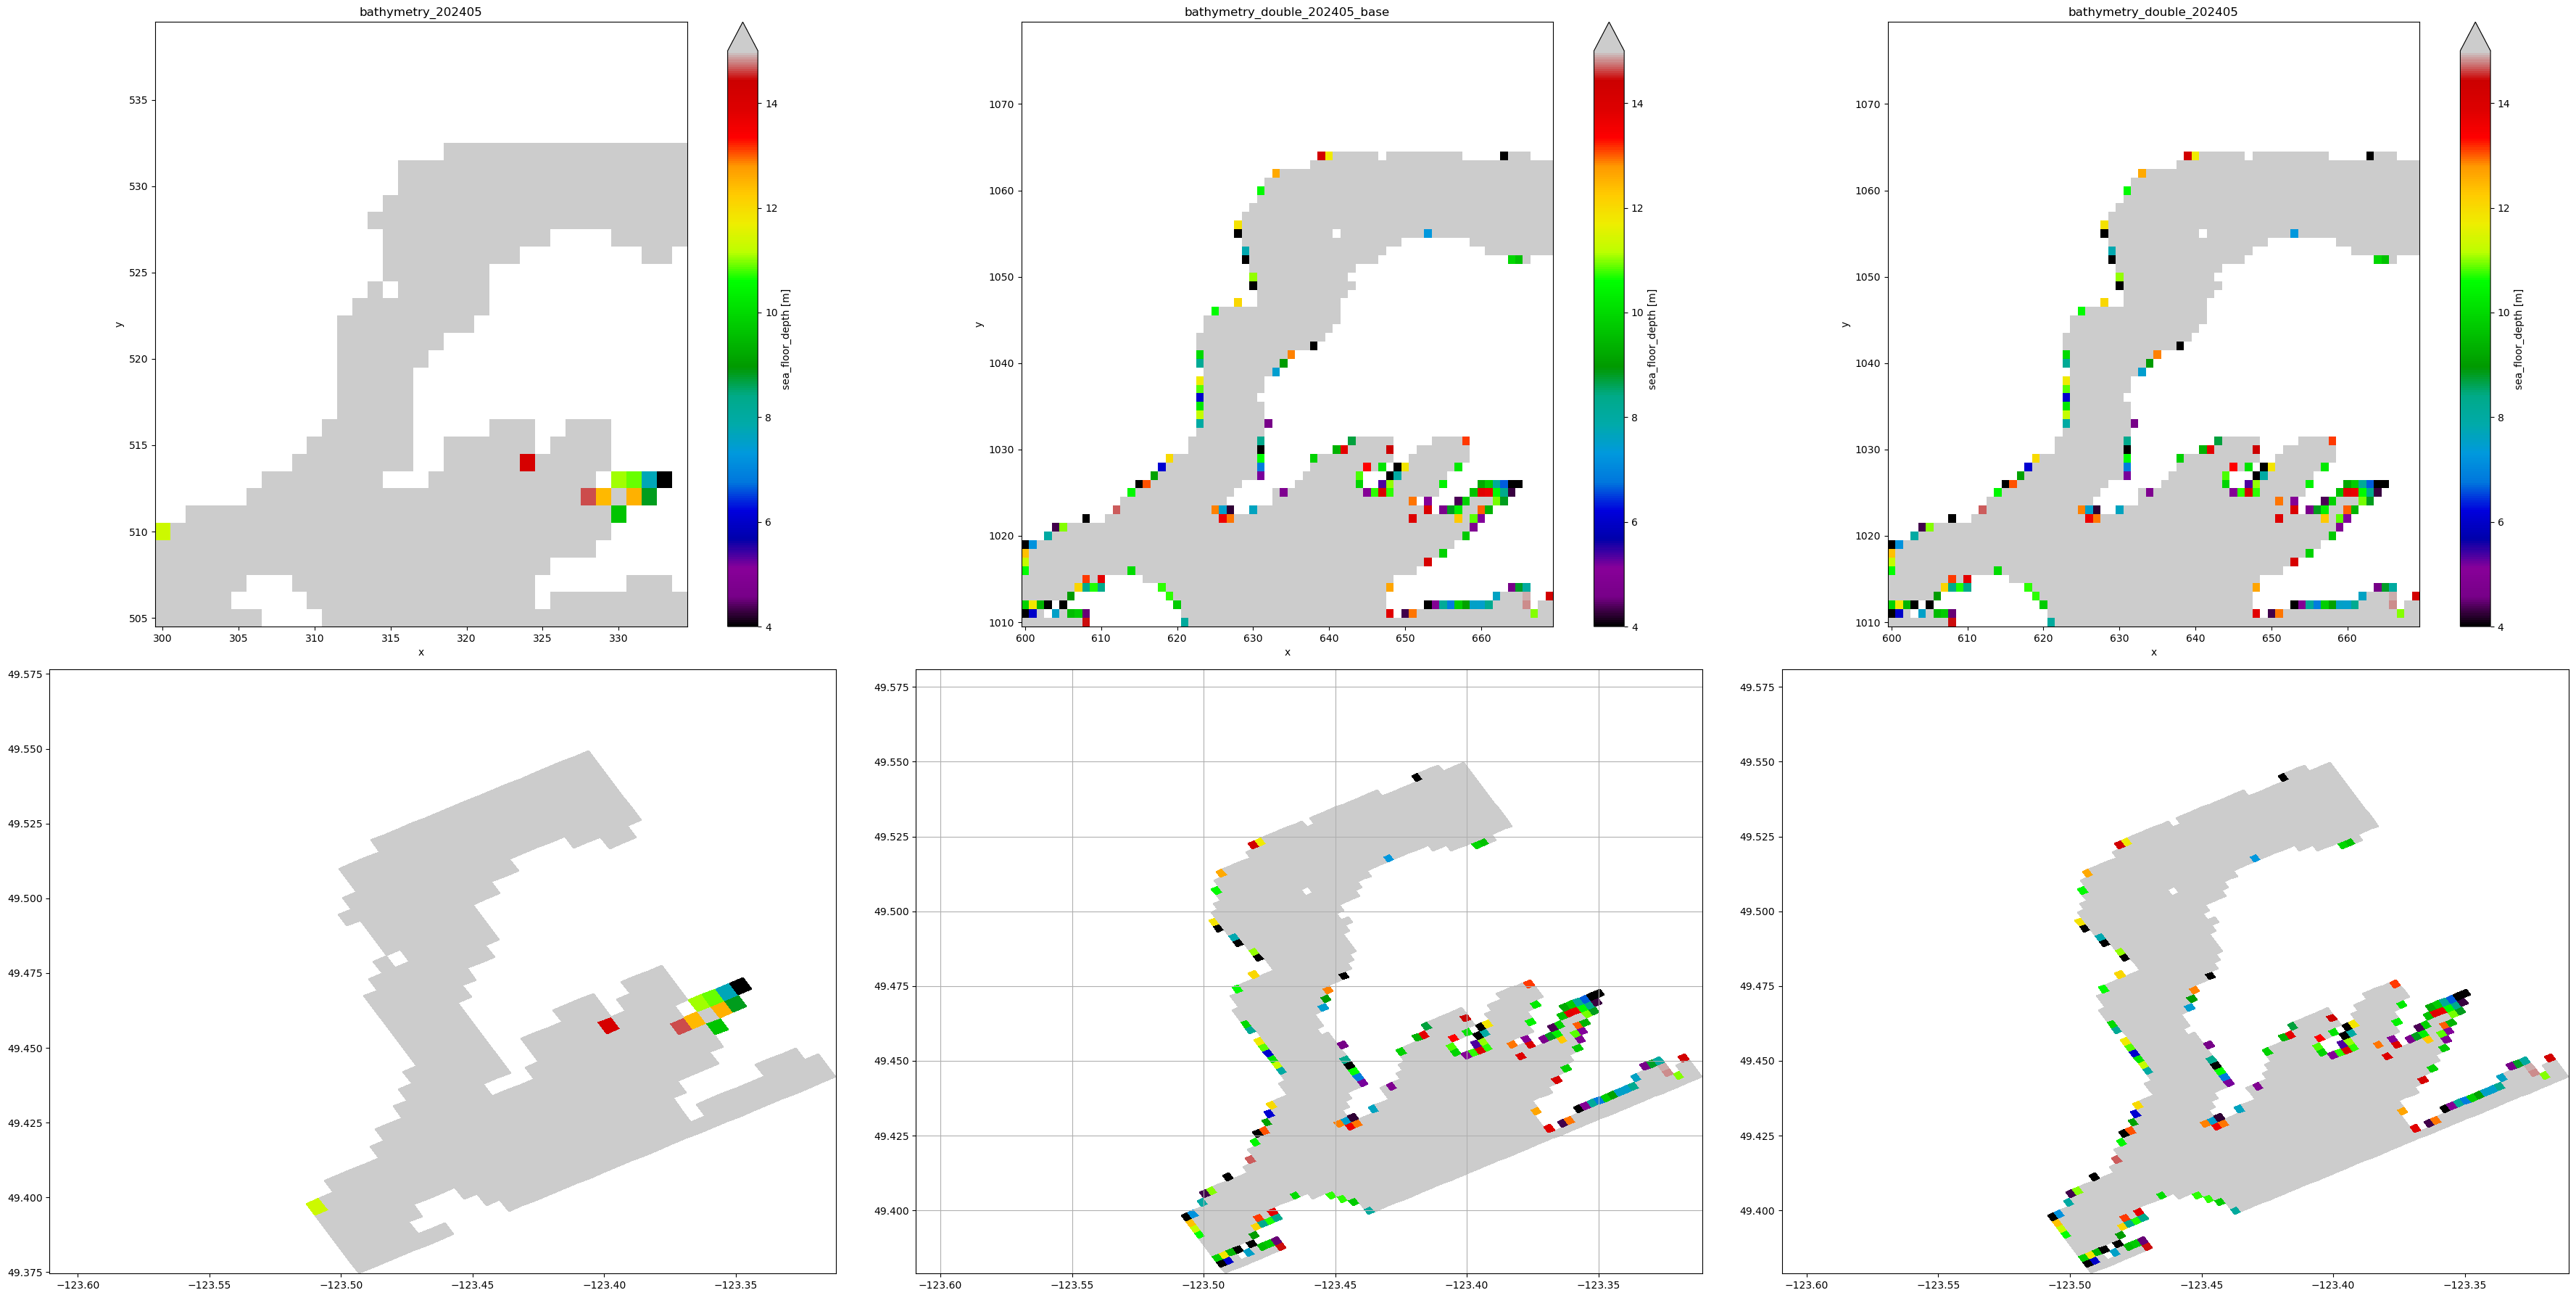

In [14]:
plot_tile(tile_x_min_max[10], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e, dbl_bathy);

### Tile 16, 11 - Anvil Island

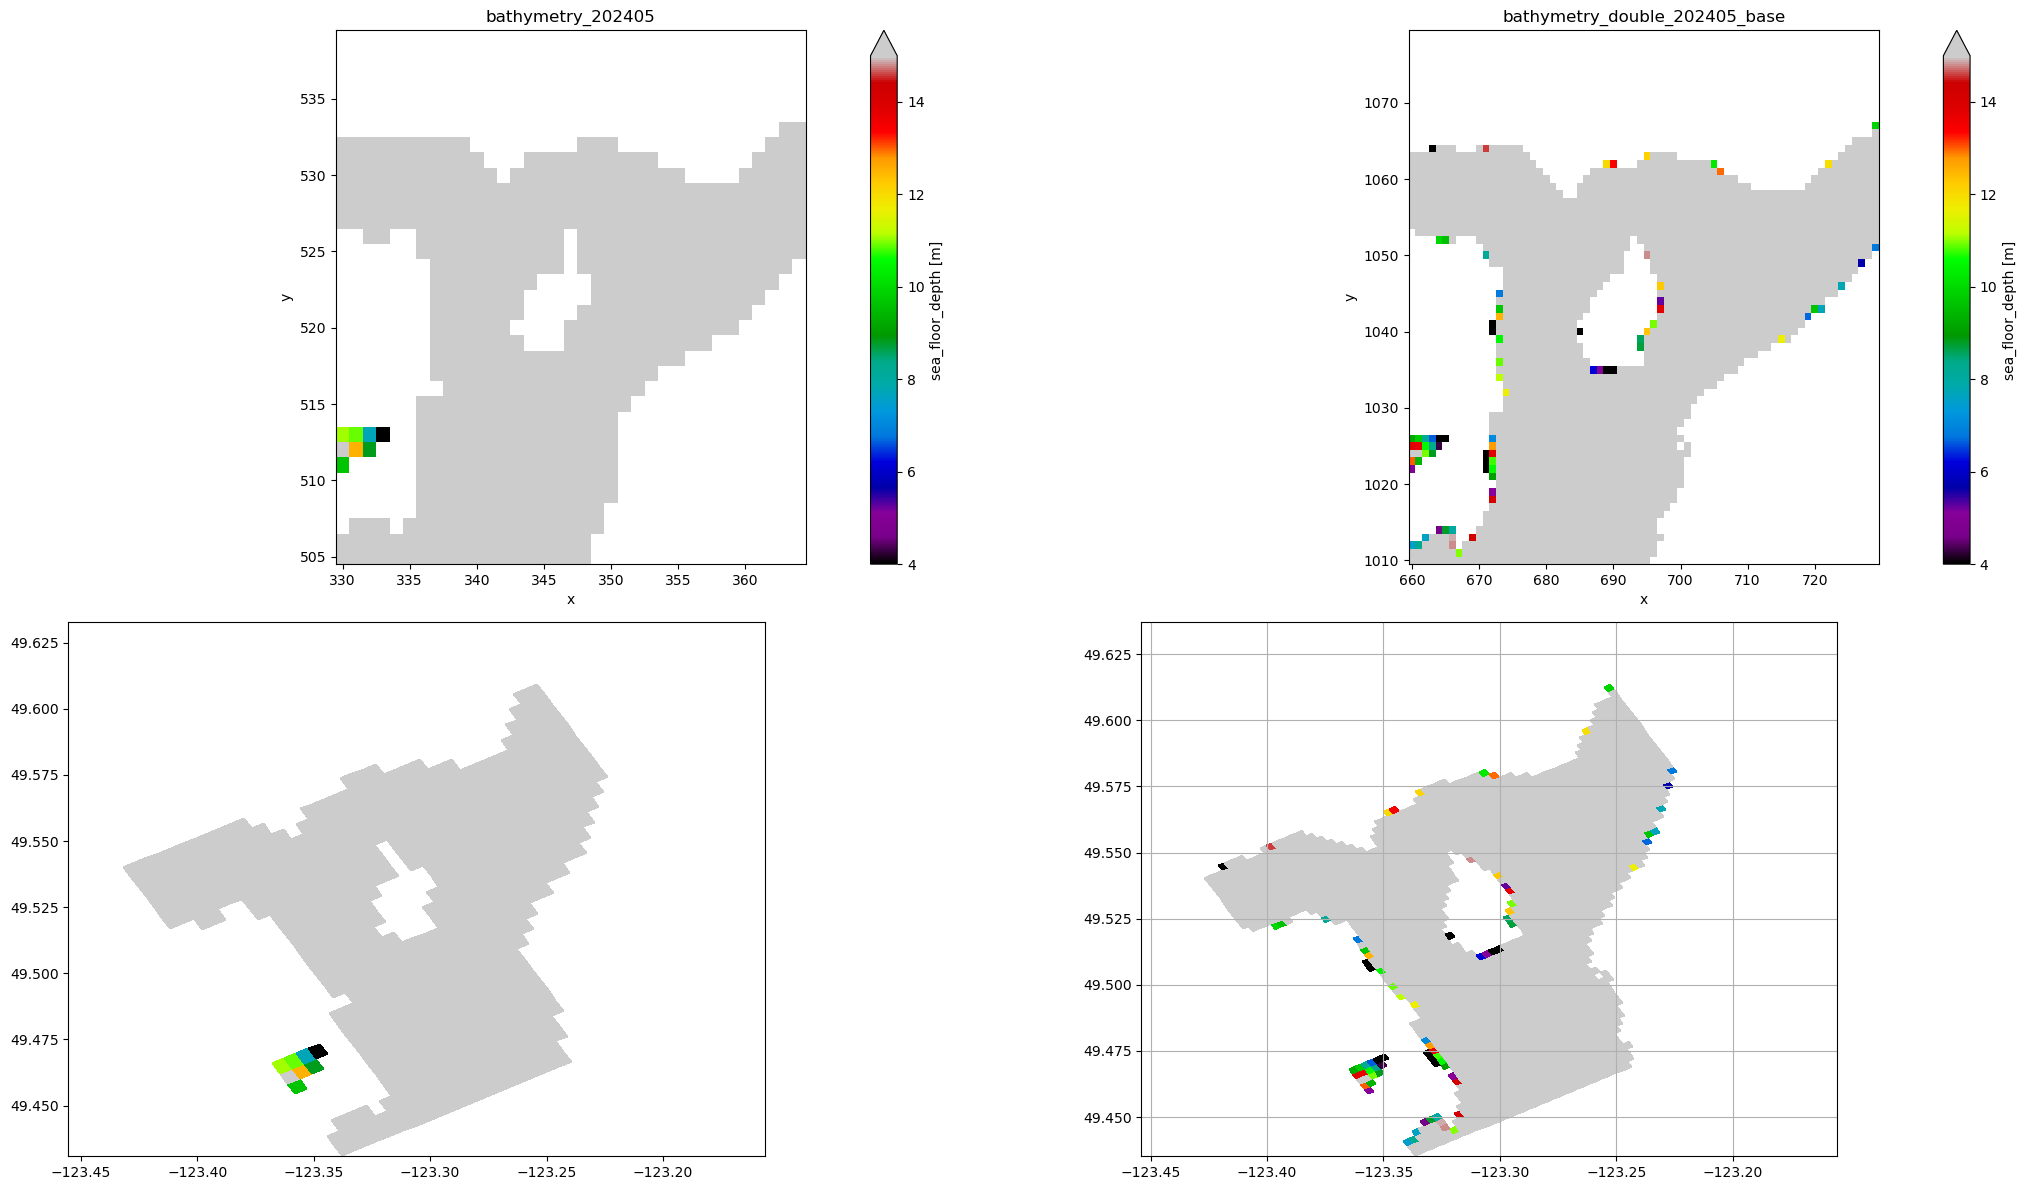

In [15]:
plot_tile(tile_x_min_max[11], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e);

### Tile 16, 12 - Britannia Beach

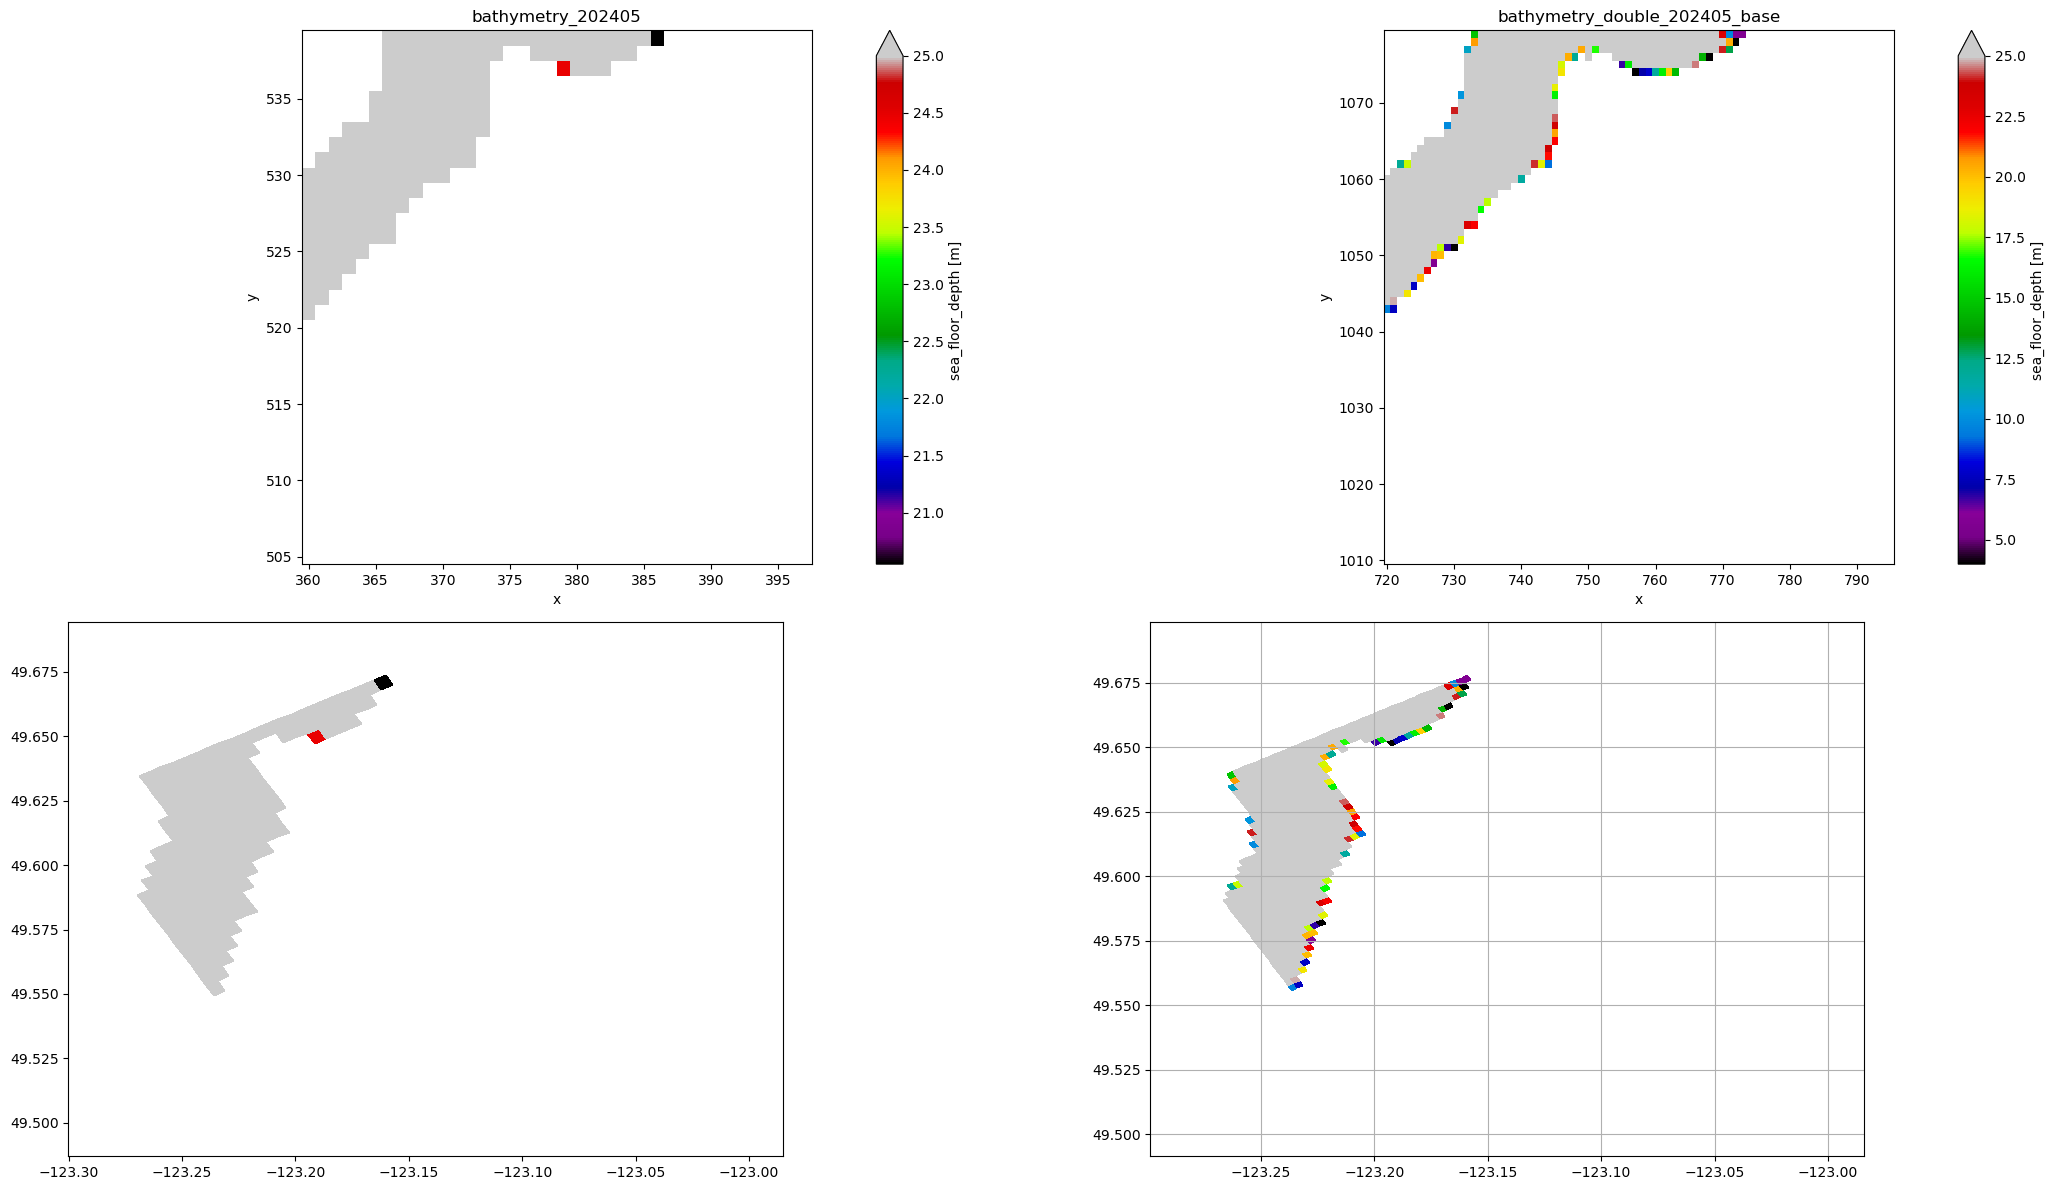

In [16]:
plot_tile(tile_x_min_max[12], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e, vmax=25);

## Row 17 - Parksville to Squamish Estuary

In [17]:
y_min_max = numpy.array([535, 570])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 17, 0

* all land

### Tile 17, 1

* all land

### Tile 17, 2

* all land

### Tile 17, 3

* all land

### Tile 17, 4

* all land

### Tile 17, 5 - Northwest Bay, Rathtrevor, Parksville, Qualicum Beach

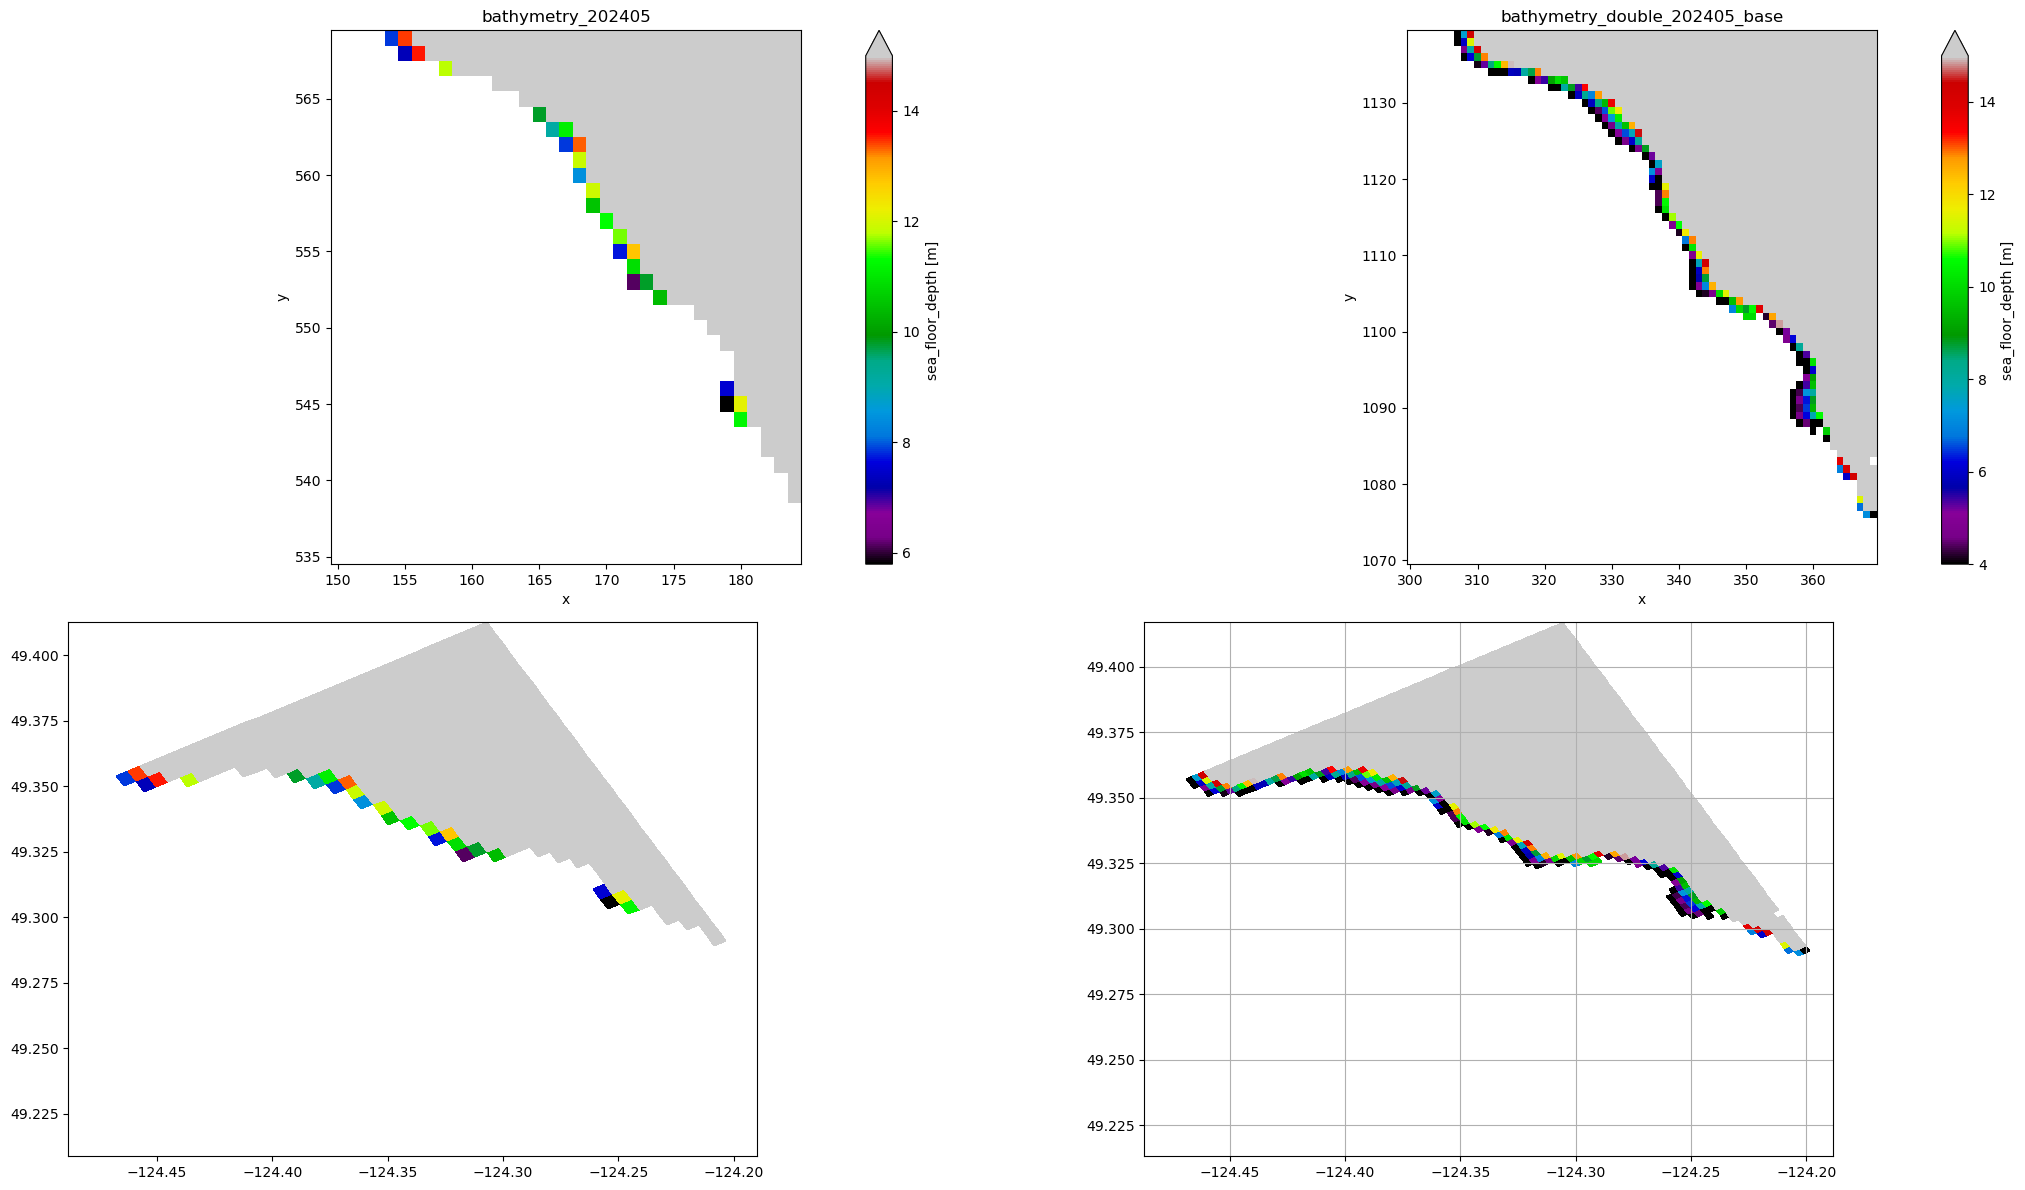

In [18]:
plot_tile(tile_x_min_max[5], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e);

### Tile 17, 6 - Northwest Bay & Lasqueti Island

* connect Cottam Point
* surface Mistaken Island


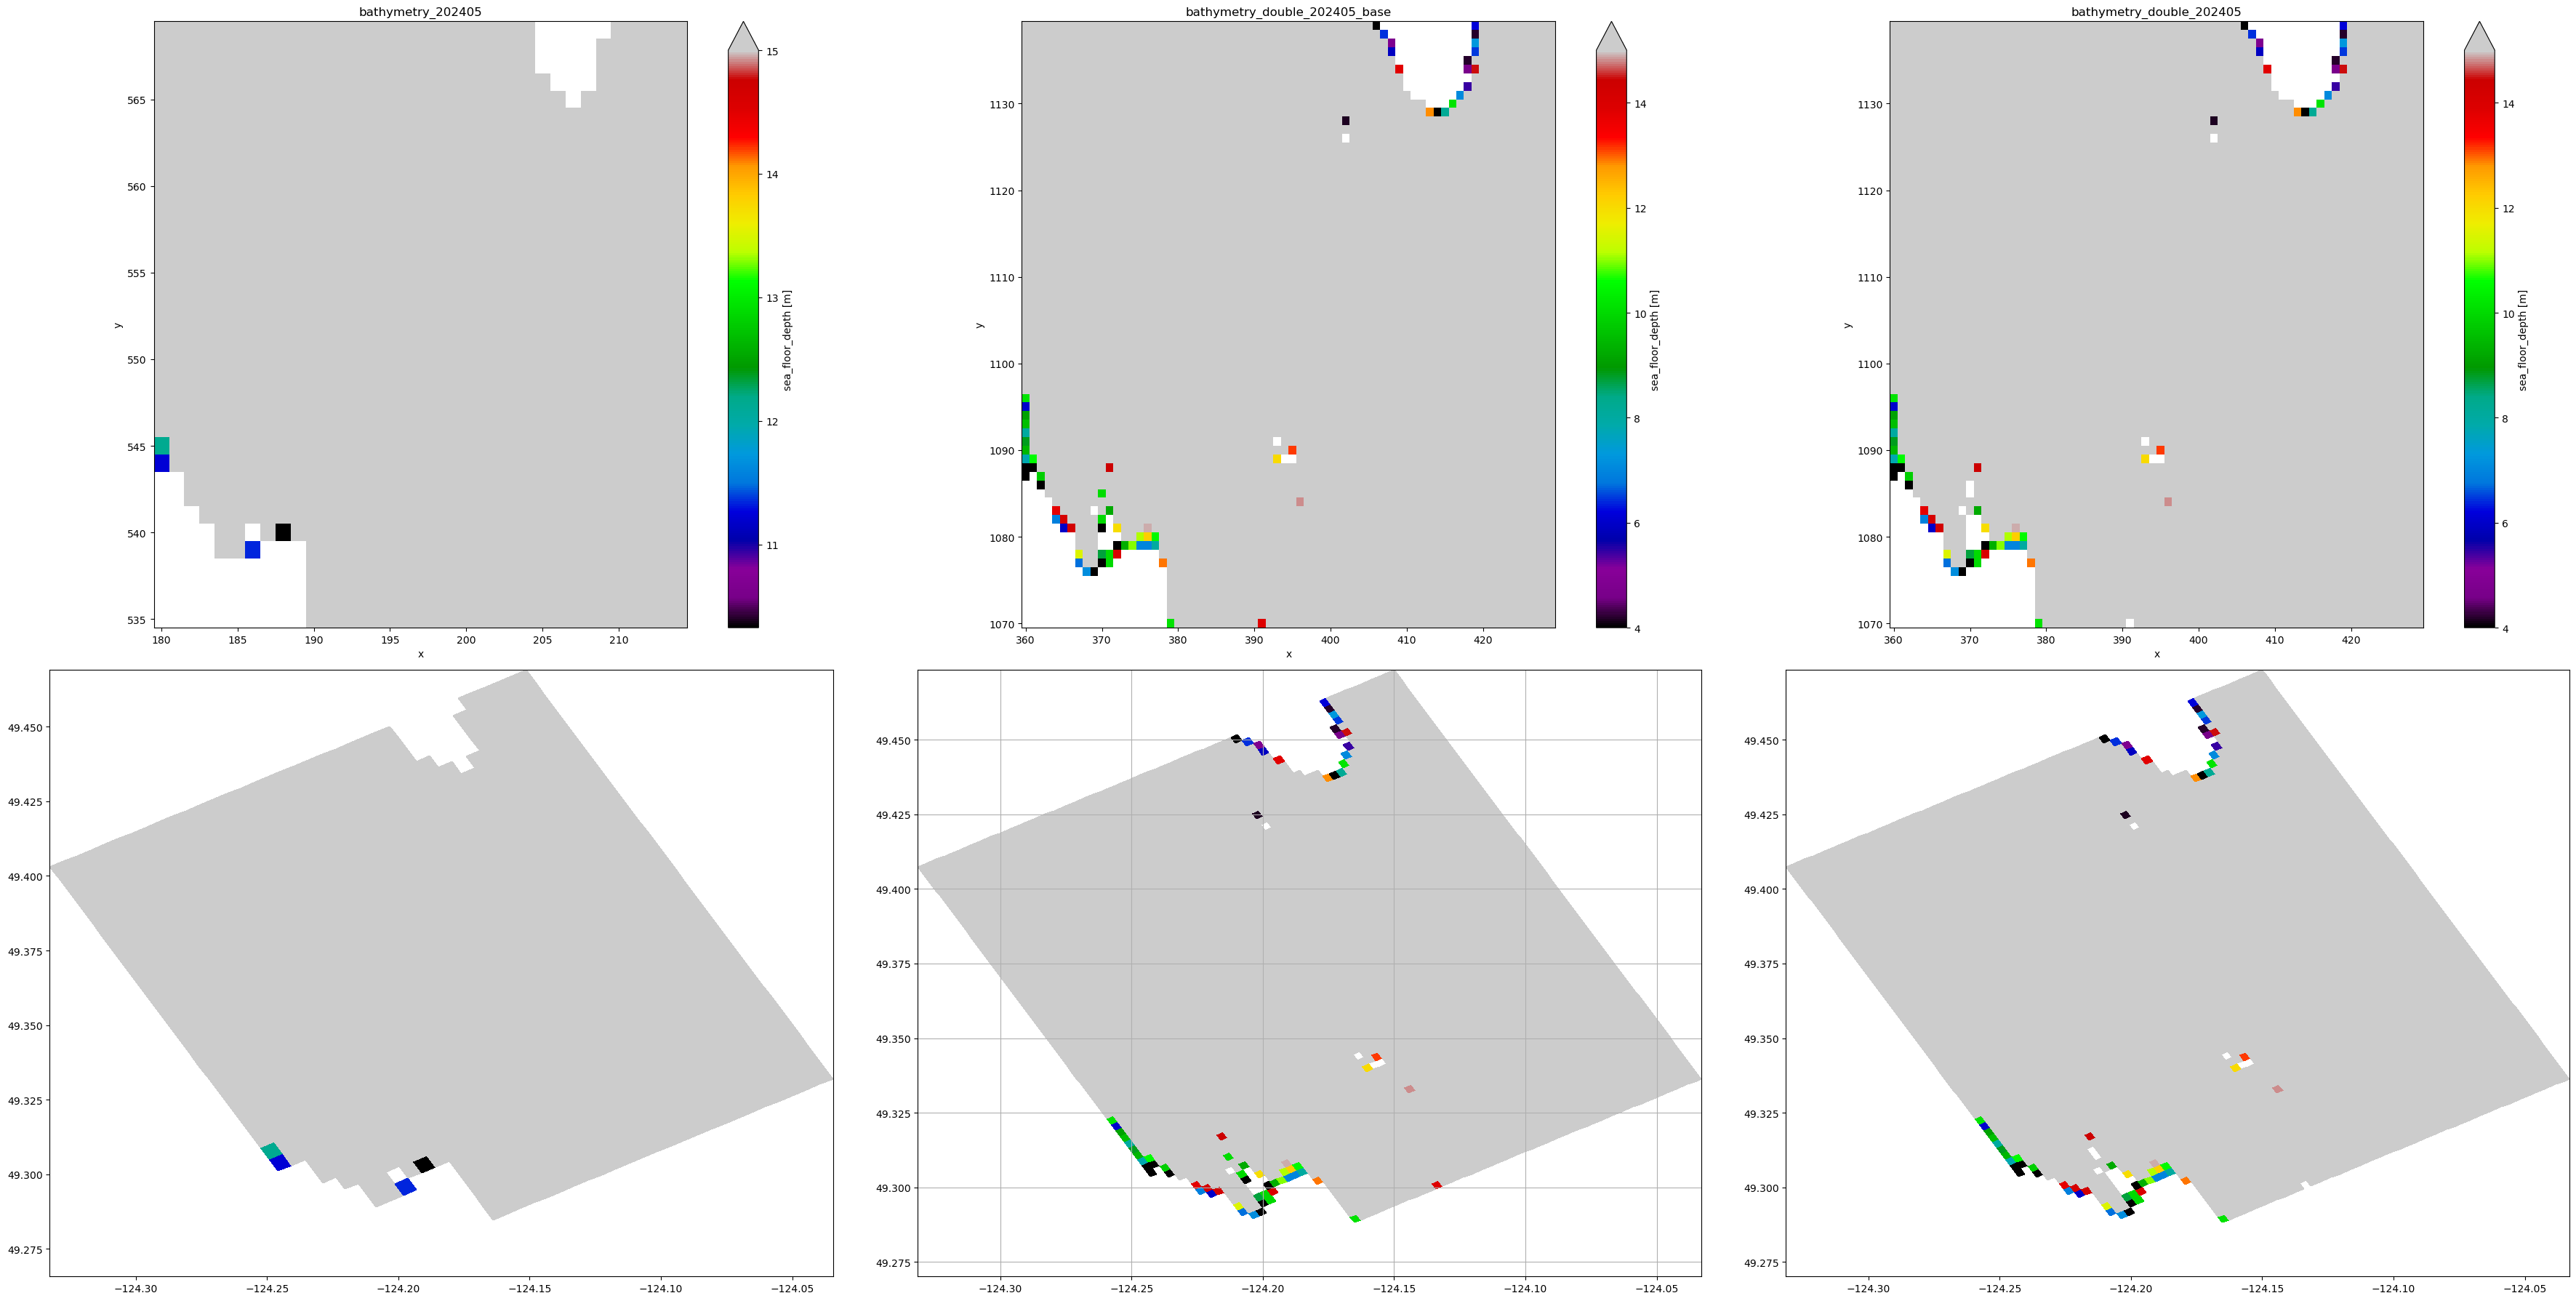

In [19]:
plot_tile(tile_x_min_max[6], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e, dbl_bathy);

### Tile 17, 7 - North & South Thormanby Islands

* remove fake islets off South Thormanby Island
* extend the north point of South Thormanby Island

* Although the northwest point of South Thormanby Island looks very different to how it appears on Google Maps,
  charts show that it is surrounded by <2m deep water.
  So, this representation is correct, given our 4m wall at the 2m isobath shoreline.


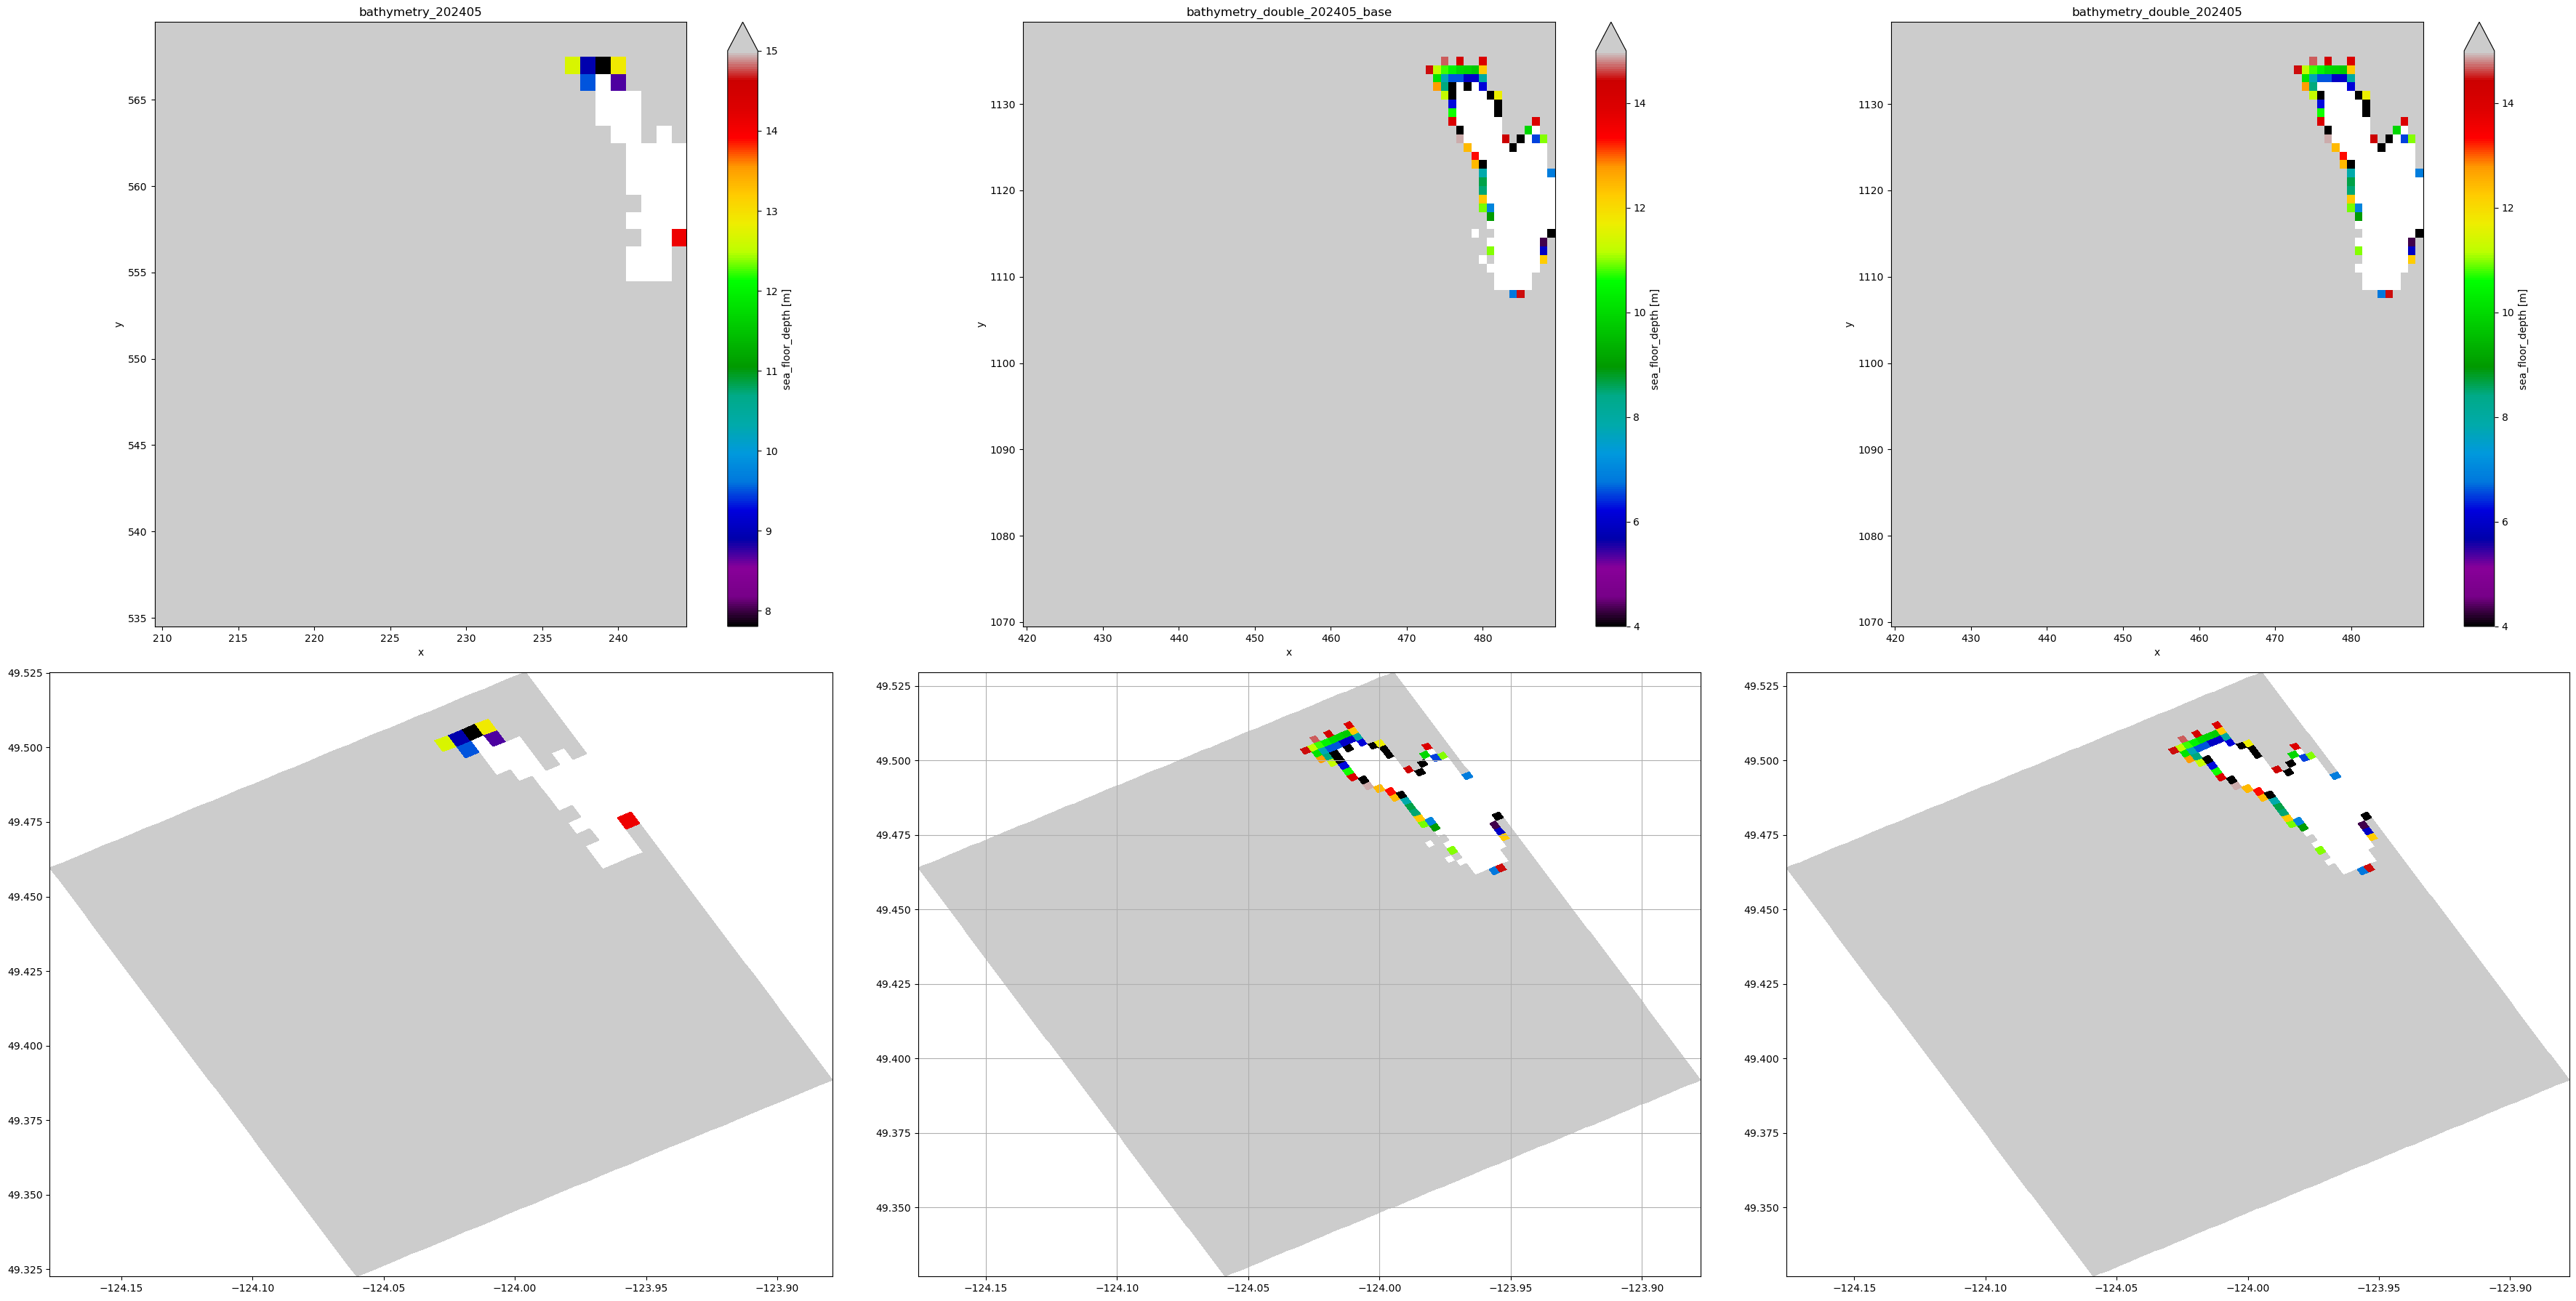

In [20]:
plot_tile(tile_x_min_max[7], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e, dbl_bathy);

### Tile 17, 8 - Sechelt to Secret Cove

* flatten east side of Welcome Passage and make passage ~2 grid cells wide
* surface Merry Island
* surface Trail Islands
* dig out Sargeant Bay to be 2x2

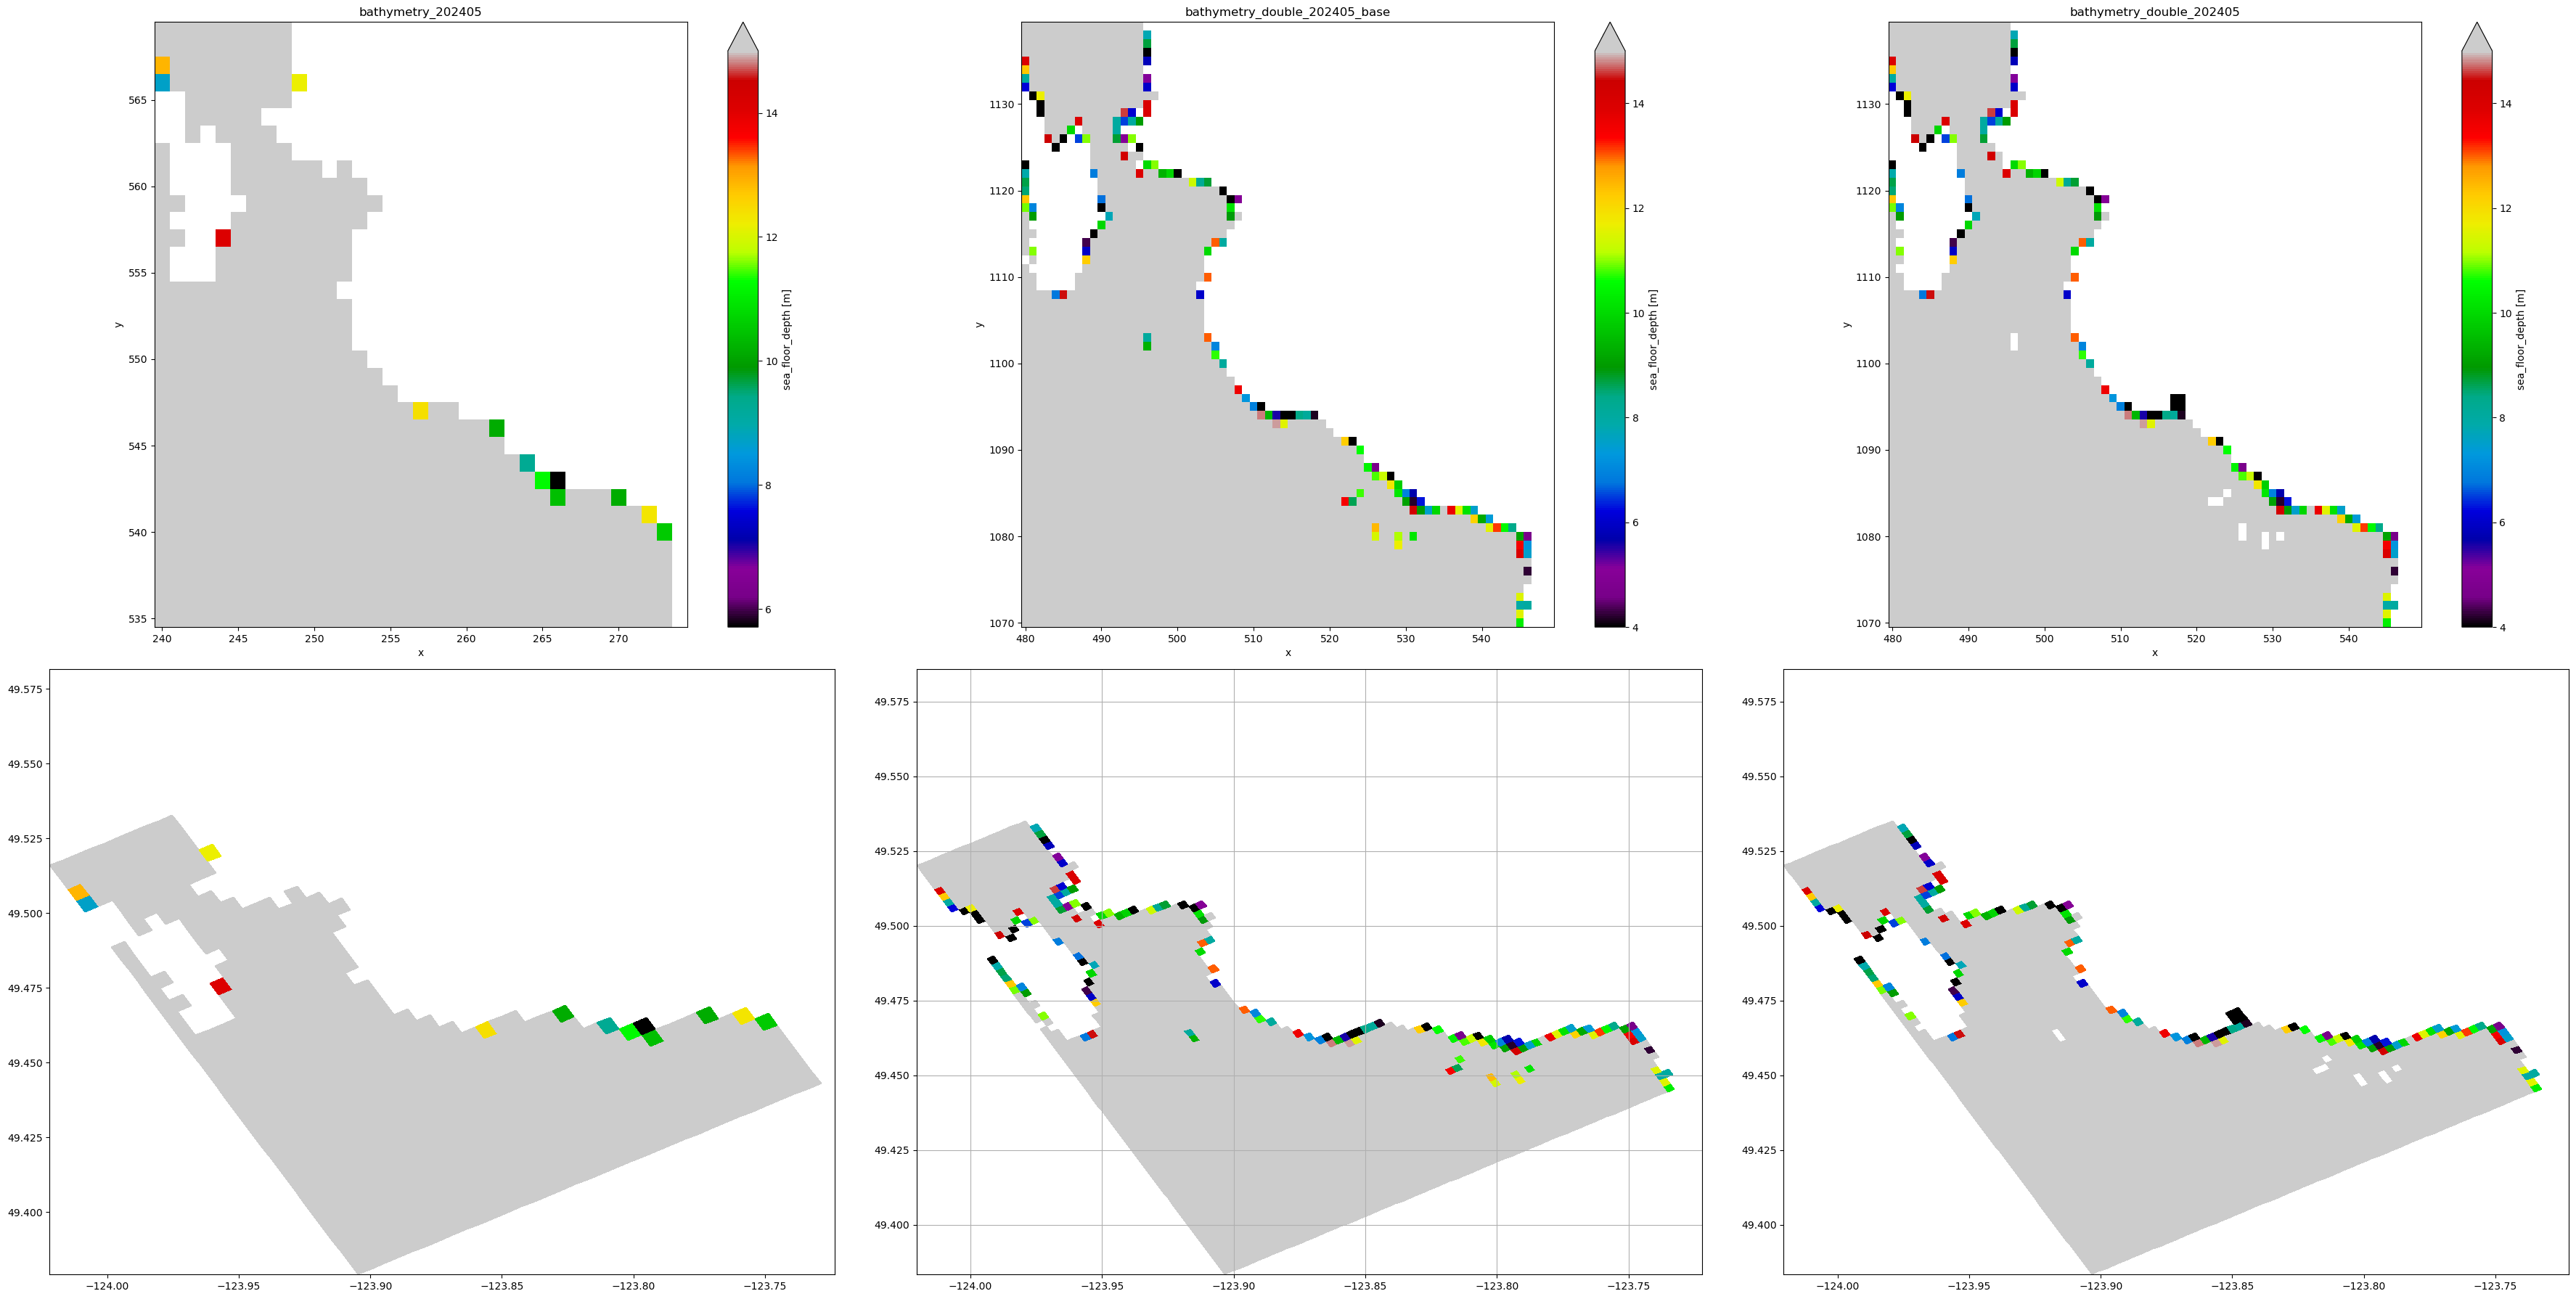

In [21]:
plot_tile(tile_x_min_max[8], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e, dbl_bathy);

### Tile 17, 9

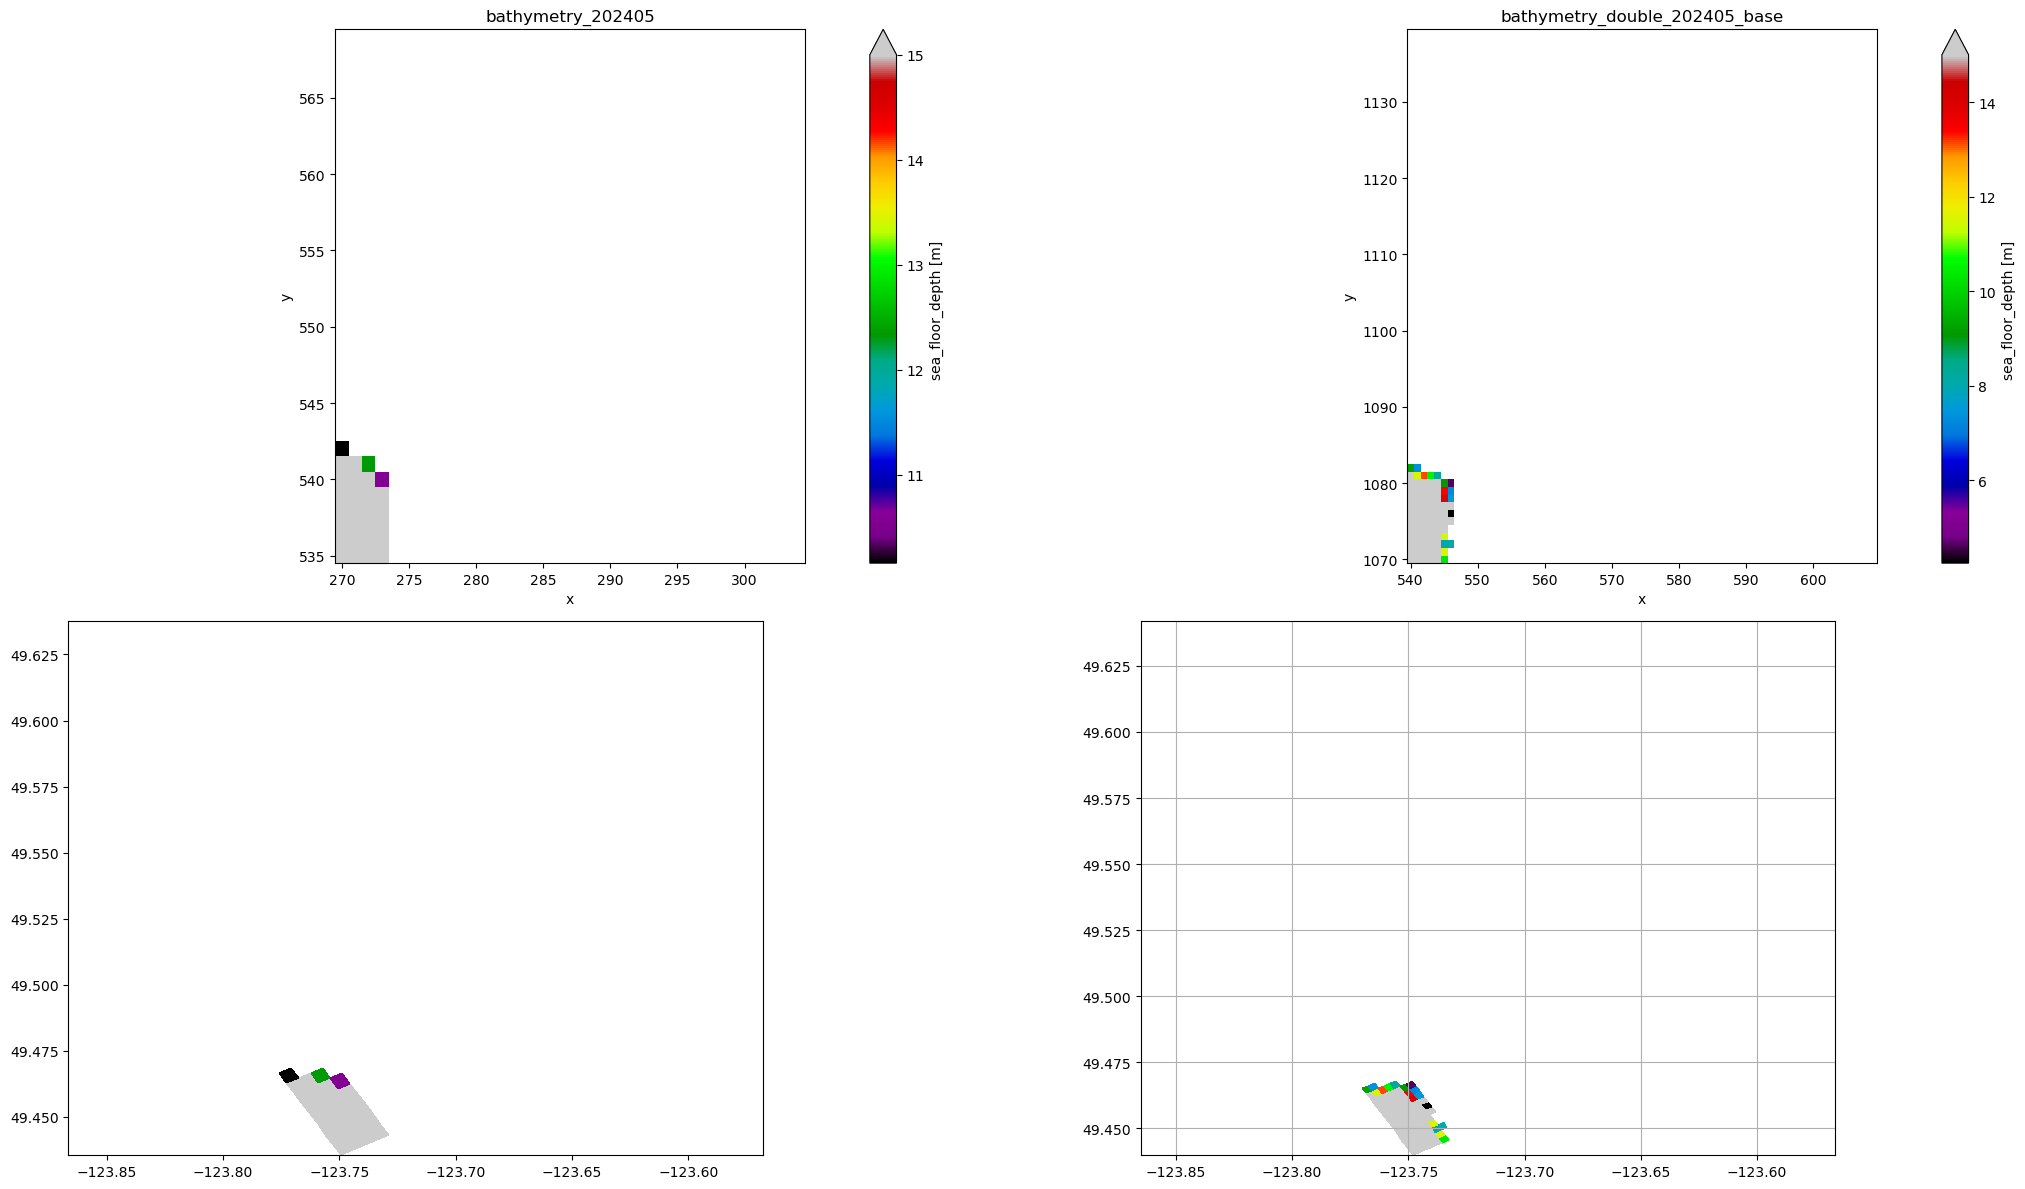

In [22]:
plot_tile(tile_x_min_max[9], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e);

### Tile 17, 10

* all land

### Tile 17, 11

* all land

### Tile 17, 12 - Squamish Estuary

* connect Squamish townsite point

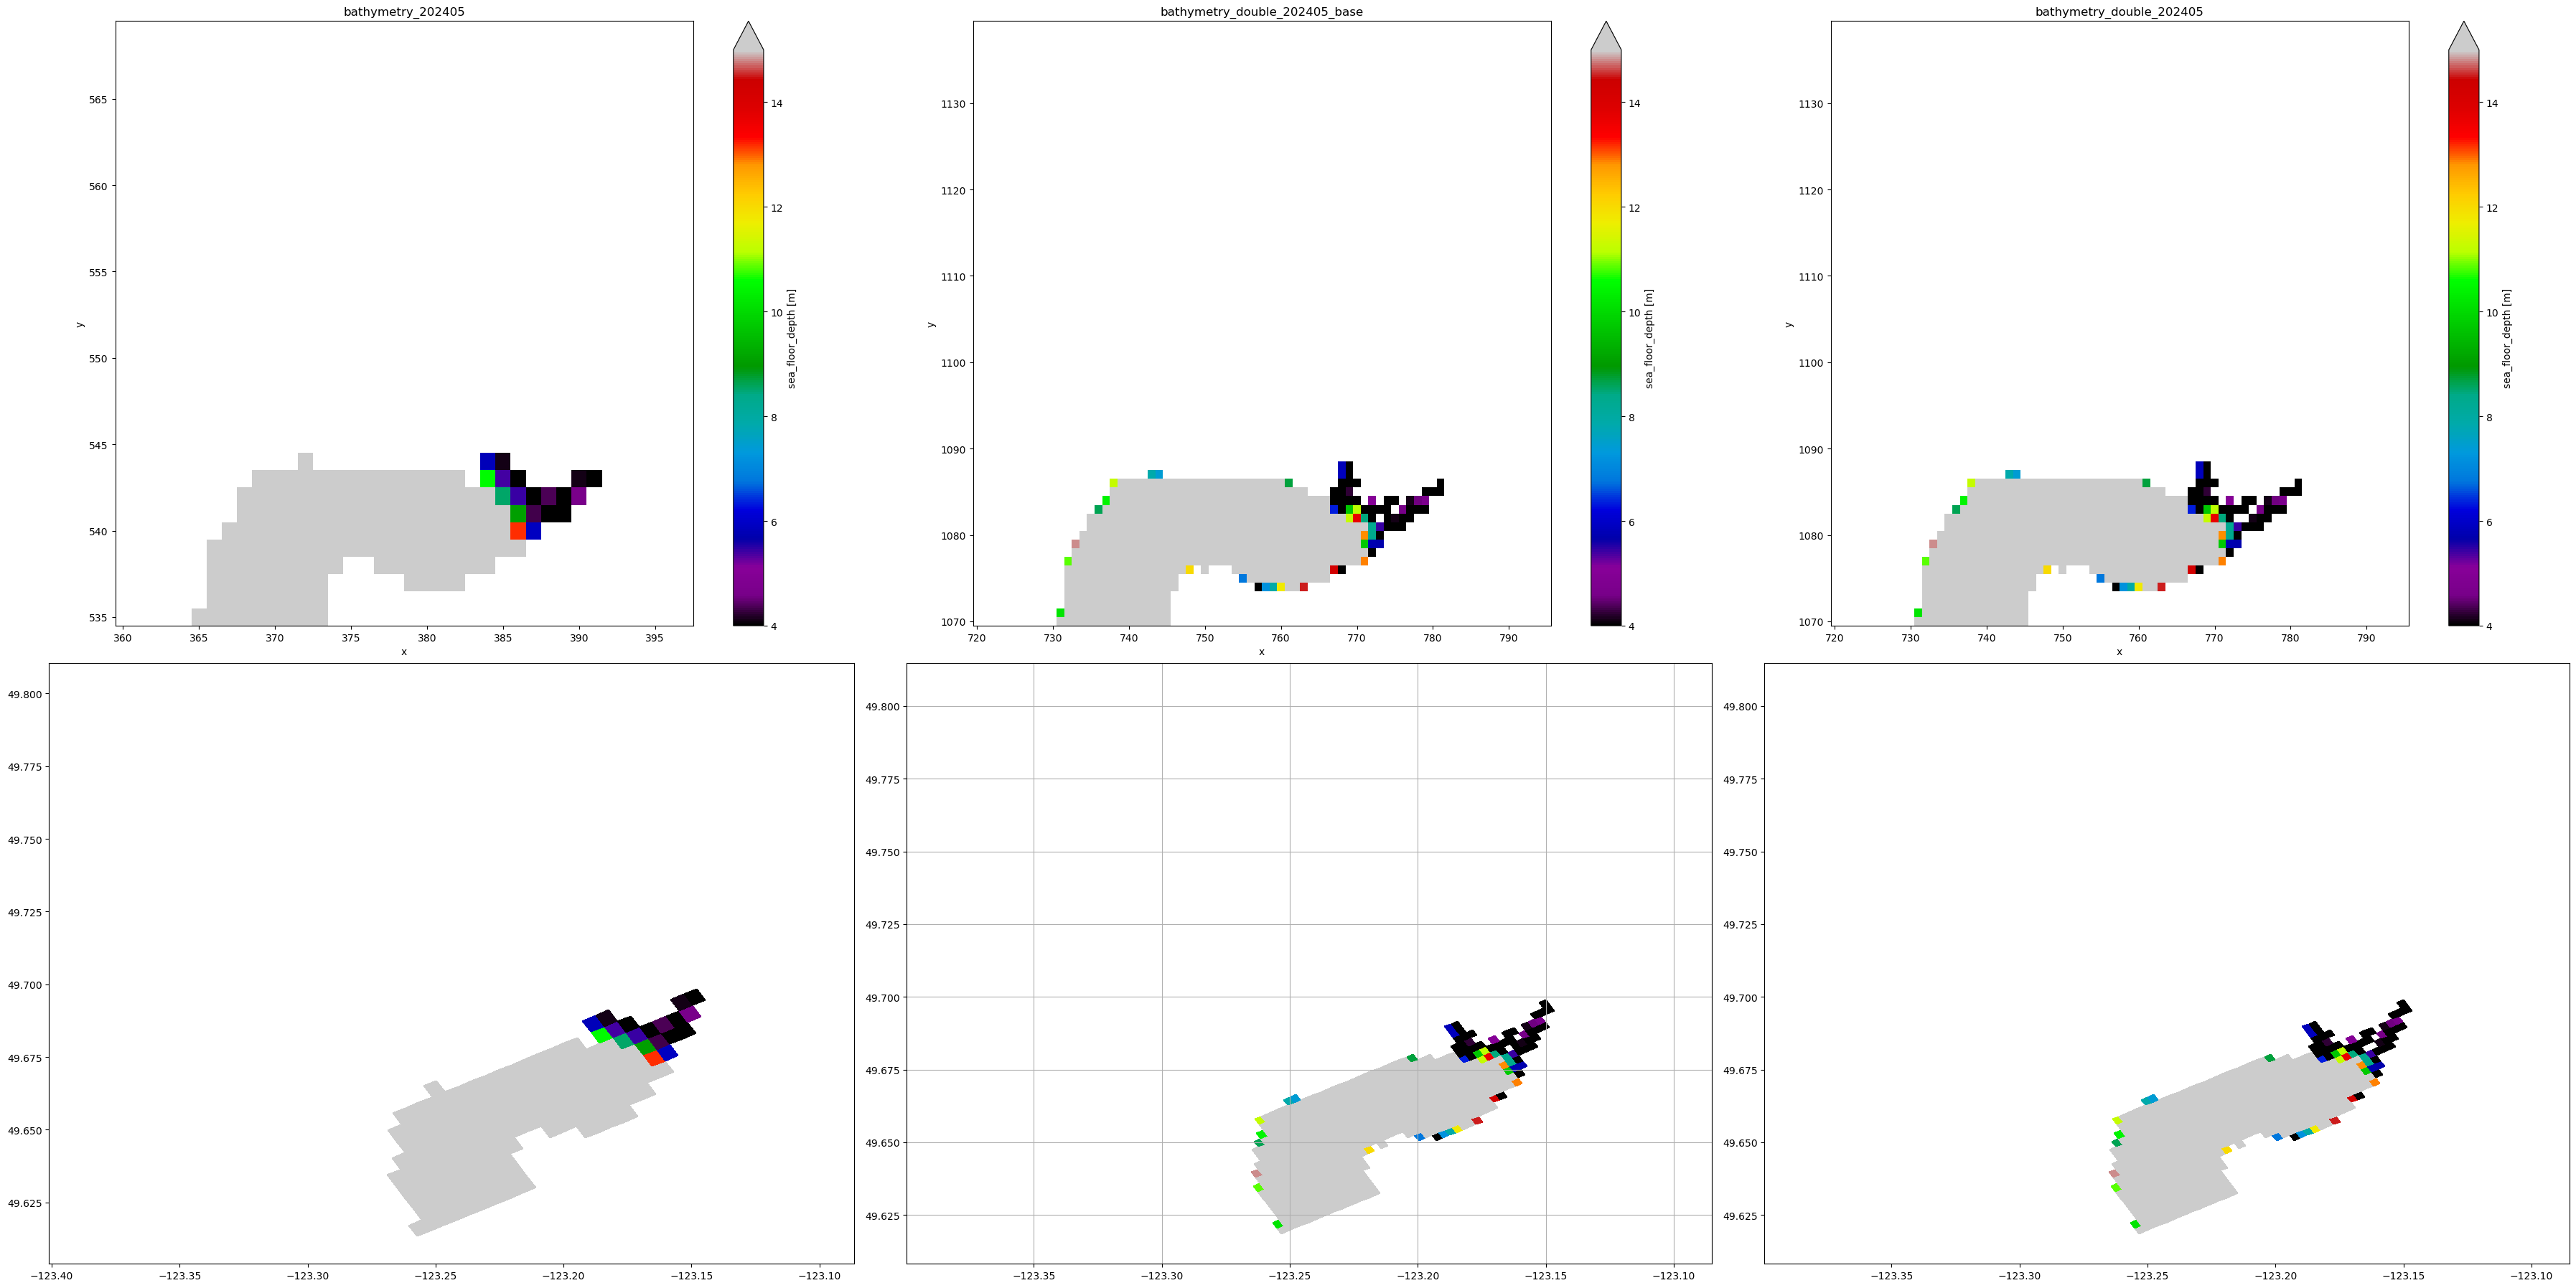

In [23]:
plot_tile(tile_x_min_max[12], y_slices, bathy, lons_e, lats_e, dbl_bathy_base, lons_dbl_e, lats_dbl_e, dbl_bathy);

In [24]:
bathy.close()
dbl_bathy_base.close()
dbl_bathy.close()